<h1 style="text-align:center;">Projet Simulation</h1>

---
**Explanation of the problem :**


The **Potential Future Depreciation (PDD)** measures the expected cumulative loss generated by an asset (or a portfolio) when its future value falls below a reference acquisition level.

Let:

- $S_a$ : acquisition value (reference level),
- $S_t$ : asset value at discrete time $t$,
- $\alpha \in [0,1]$ : critical threshold,
- $T$ : time horizon.

The incremental depreciation at time $t$ is defined as

$$
\lambda_t(r,\sigma,S_a,S_0)
=
(S_a - S_{t+1})^+
\mathbf{1}_{\{S_{t+1}\le \alpha S_a\}}
\mathbf{1}_{\{\sup_{u\in[t-1/2,t]} S_u \le S_a\}}.
$$

The total PDD over the horizon $T$ is

$$
\text{PDD}_T
=
\mathbb{E}^{\mathbb{Q}}
\left[
\sum_{t=0}^{T-1}
\lambda_t(r,\sigma,S_a,S_0)
\right].
$$


---


Because the payoff is additive over time, PDD naturally admits a recursive dynamic programming formulation:

$$
V_t(S_t)
=
\mathbb{E}^{\mathbb{Q}}
\left[
\lambda_t + V_{t+1}(S_{t+1})
\mid S_t
\right],
\qquad
V_T = 0.
$$


## Sommaire :

* [**1. Un seul actif et une seule période**](#1)
    * [1.1. Méthode naïve](#1_1)
    * [1.2. Méthode raffinée](#1_2)
    * [1.3. Comparaison des méthodes](#1_3)
* [**2. Un seul actif et plusieurs périodes**](#2)
    * [2.1. Méthode naïve](#2_1)
    * [2.2. Méthode raffinée](#2_2)
    * [2.3. Comparaison des méthodes](#2_3)
    * [2.4. Choc des paramètres $\sigma$ et $r$](#2_4)
    * [2.5. Sensibilité de la PDD : Les grecques](#2_5) 
        - [2.5.1 Vega]()
        - [2.5.2 Rho]()
        - [2.5.3 Delta]()
* [**3. Plusieurs actifs**](#3)
    * [3.1. Construction d’un model point sur une période](#3_1)
    * [3.2 Méthodes ligne à ligne](#3_2)
    * [3.3 Comparaison des méthodes](#3_3)
        - [3.3.1 Résultats]()
        - [3.3.2 Temps de calcul]()

In [1069]:
# ====================== IMPORTATION MODULES ====================== #

import pandas as pd
import numpy as np
from scipy.stats import shapiro, norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import requests
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy.linalg import cholesky
import time
from tabulate import tabulate

<a id='1'></a>

# 1. Un seul actif et une seule période

Soit $(\Omega, \mathcal{F}, \mathbb{Q})$ un espace probabilisé, soit $(\mathcal{W}_t)_{t>0}$ un mouvement brownien sous $\mathbb{Q}$ et $(\mathcal{S}_t)_{t>0}$ représentant la trajectoire d'un actif.

Sous $\mathbb{Q}$, la dynamique de $\mathcal{S}$ s'écrit :

$$
\frac{dS_t}{S_t} = r \, dt + \sigma \, dW_t
$$

**Solution de l'EDS :** 

$$
d(\ln(S_t)) = \frac{1}{S_t} dS_t - \frac{1}{2} \frac{1}{S_t^2} (dS_t)^2
\implies d(\ln(S_t)) = \frac{1}{S_t} \big(S_t (r \, dt + \sigma \, dW_t)\big) - \frac{1}{2} \sigma^2 dt
\implies d(\ln(S_t)) = \left(r - \frac{1}{2} \sigma^2\right) dt + \sigma dW_t
$$

$$
\ln(S_t) = \ln(S_0) + \left(r - \frac{1}{2} \sigma^2\right)t + \sigma W_t
\implies S_t = S_0 \exp\left(\left(r - \frac{1}{2} \sigma^2\right)t + \sigma W_t\right)
$$


$$
\implies S_{t_k} = S_{t_{k-1}} \exp\left(\left(r - \frac{1}{2} \sigma^2\right)(t_k - t_{k-1}) + \sigma \left(W_{t_k} - W_{t_{k-1}}\right)\right)
$$

---

In [948]:
# ====================== Variables ====================== #

r = 0.02  # Taux sans risque
sigma = 0.3  # Volatilité
Sa = 110  # Prix d'acquisition
S0 = 100  # Prix initial
alpha = 0.75  # Facteur de dépréciation
T = 1  # Durée de la période
N = 1000  # Nombre de simulations
dt = 0.01  # Pas de temps
steps = int(T / dt)  # Nombre de pas dans la discrétisation

<a id="1_1"></a>
## 1.1 Méthode naïve

In [949]:
# ====================== Simulation 1 trajectoire naïve ====================== #

def simulate_trajectory_one_period(S0, r, sigma, dt, steps):
    """
    Simule une trajectoire unique du processus de prix d'une action et calcule les métriques associées.

    Arguments :
    - S0 : Prix initial de l'actif
    - r : Taux sans risque
    - sigma : Volatilité
    - dt : Pas de temps
    - steps : Nombre de pas dans la discrétisation

    Retourne :
    - trajectory : Trajectoire simulée (logarithmique puis exponentielle)
    - lambda_0 : Pénalité associée à l'absence de dépassement (si applicable)
    - vec_active : Vecteur indiquant les dépassements de la barrière log(Sa)
    - bool_active : Booléen indiquant si il y a eu dépassement
    """
    # Génère les incréments brownien
    Z = np.random.normal(0, 1, steps)
    vec_active = np.zeros(steps)

    # Initialisation de la trajectoire
    trajectory = np.zeros(steps + 1)
    trajectory[0] = np.log(S0)

    logSa = np.log(Sa)

    # Calcul des points suivant le schéma d'Euler
    for t in range(steps):
        trajectory[t + 1] = trajectory[t] + (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t]

        if t >= steps // 2:
            vec_active[t] = vec_active[t - 1] + (trajectory[t] > logSa)

    # Conversion logarithmique en exponentielle
    trajectory = np.exp(trajectory)
    S_1 = trajectory[-1]
    bool_active = (vec_active[-1] == 0)  # Si le dernier == 0 alors il n'y aura pas eu de dépassement
    lambda_0 = (Sa - S_1) * (S_1 <= alpha * Sa) * bool_active  # REMARQUE : Actualiser ou pas ?

    return trajectory, lambda_0, vec_active, bool_active

In [950]:
# ====================== Simulation N trajectoire naïve + PDD ====================== #

def simulate_multiple_trajectories_one_period(N, S0, r, sigma, dt, steps, Sa, alpha):
    """
    Simule N trajectoires du processus de prix d'une action sur une période et calcule les métriques associées.

    Arguments :
    - N : Nombre de trajectoires à simuler
    - S0 : Prix initial de l'actif
    - r : Taux sans risque
    - sigma : Volatilité
    - dt : Pas de temps
    - steps : Nombre de pas dans la discrétisation
    - Sa : Barrière de prix (prix d'acquisition)
    - alpha : Facteur de dépréciation

    Retourne :
    - all_trajectories : Liste de toutes les trajectoires simulées
    - PDD_0 : Valeur de la PDD pour l'actif unique
    - deprecation_prob : Probabilité de dépréciation
    """
    all_trajectories = []
    lambda_0_list = []
    deprecation_prob = 0

    for _ in range(N):
        trajectory, lambda_0, _, bool_active = simulate_trajectory_one_period(S0, r, sigma, dt, steps)
        all_trajectories.append(trajectory)
        lambda_0_list.append(lambda_0)
        deprecation_prob += bool_active and (trajectory[-1] <= alpha * Sa)

    # Calcul de la pénalité moyenne et de la probabilité de dépréciation
    PDD_0 = np.mean(lambda_0_list)
    deprecation_prob /= N

    return all_trajectories, PDD_0, deprecation_prob, lambda_0_list

In [352]:
# ====================== Résultat PDD ====================== #

T = 1           # Durée de la période
N = 10000       # Nombre de simulations
dt = 0.0001     # Pas de temps
steps = int(T / dt)  # Nombre de pas dans la discrétisation

all_trajectories, PDD_naive, prob_naive, lambda_0_list = simulate_multiple_trajectories_one_period(N, S0, r, sigma, dt, steps, Sa, alpha)

# Affichage amélioré des résultats
print("=" * 50)
print("         Résultats de la simulation PDD naïve        ")
print("=" * 50)
print(f"Nombre de simulations (N)                : {N}")
print(f"Durée de la période (T)                  : {T} an(s)")
print(f"Pas de temps (dt)                        : {dt:.6f} an(s)")
print(f"Nombre de pas dans la discrétisation     : {steps}")
print("-" * 50)
print(f"PDD (méthode naïve)                    : {PDD_naive:.4f}")
print(f"Probabilité de dépréciation (naïve)      : {prob_naive:.6f}")
print("=" * 50)

         Résultats de la simulation PDD naïve        
Nombre de simulations (N)                : 10000
Durée de la période (T)                  : 1 an(s)
Pas de temps (dt)                        : 0.000100 an(s)
Nombre de pas dans la discrétisation     : 10000
--------------------------------------------------
PDD (méthode naïve)                    : 10.8476
Probabilité de dépréciation (naïve)      : 0.262100


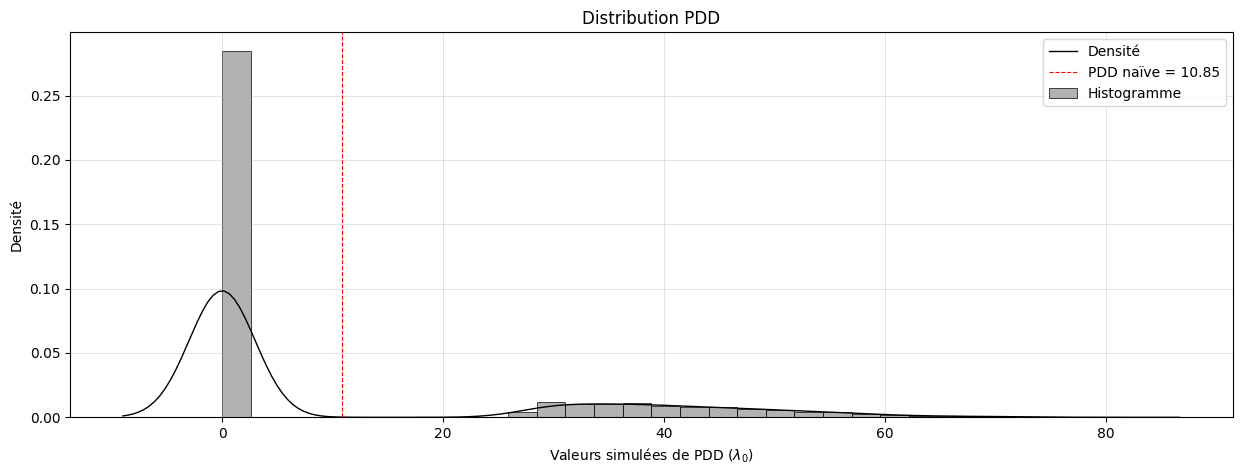

In [353]:
# ====================== Distribution PDD ====================== #

# Création de l'histogramme et de la courbe de densité
plt.figure(figsize=(15, 5))
sns.histplot(data=lambda_0_list, kde=False, stat="density", bins=30, color="gray", alpha=0.6, edgecolor="black", linewidth=0.5, label="Histogramme")
sns.kdeplot(data=lambda_0_list, color="black", linewidth=1, label="Densité")

# Ajout du trait rouge pour PDD_naive
plt.axvline(x=PDD_naive, color="red", linestyle="--", linewidth=0.8, label=f"PDD naïve = {PDD_naive:.2f}")

# Ajout de labels et d'une légende
plt.title("Distribution PDD", fontsize=12)
plt.xlabel("Valeurs simulées de PDD ($\lambda_0$)", fontsize=10)  # Utilisation correcte de \\lambda
plt.ylabel("Densité", fontsize=10)
plt.legend(fontsize=10)  # Légende incluant PDD_naive
plt.grid(True, linewidth=0.5, alpha=0.5)  # Grille fine
plt.savefig("distribution_PDD.png", dpi=300, bbox_inches="tight")
plt.show()

<a id="1_2"></a>
## 1.2 Méthode raffinée

Soit $(\Omega, \mathcal{F}, \mathbb{P})$ un espace probabilisé.

On définit le pont brownien $(\mathcal{Z}_t^{a,b})_{t \in [t_1, t_2]}$ par :

$$
\mathcal{Z}_t^{a,b} = W_t + \frac{b - W_{t_2}}{t_2 - t_1}(t - t_1),
$$
où :
- $ W_t $ est un mouvement brownien standard défini sur l'intervalle $[t_1, t_2]$,
- $ a $ et $ b $ sont les valeurs du processus au début et à la fin de l'intervalle, avec $ \mathcal{Z}_{t_1}^{a,b} = a $ et $ \mathcal{Z}_{t_2}^{a,b} = b $.

### Proba de franchissement barrière :

$$
P\left(\max_{t \in [t_1, t_2]} \mathcal{Z}_t^{a,b} > M \right) 
= P\left(\max_{t \in [t_1, t_2]} W_t > M\, \Big| \, W_{t_1} = a, \, W_{t_2} = b \right) 
= \exp\left(-\frac{2(a - M)(b - M)}{(t_2 - t_1)}\right).
$$

In [951]:
# ====================== Simulation 1 trajectoire raffinée ====================== #

def simulate_trajectory_one_period_refined(S0, r, sigma, dt, steps):
    """
    Simule une trajectoire unique du processus de prix d'une action, en utilisant une approche raffinée
    avec probabilités intermédiaires de dépassement basées sur le pont brownien.

    Arguments :
    - S0 : Prix initial de l'actif
    - r : Taux sans risque
    - sigma : Volatilité
    - dt : Pas de temps
    - steps : Nombre de pas dans la discrétisation

    Retourne :
    - trajectory : Trajectoire simulée (logarithmique puis exponentielle)
    - lambda_0_naive : Pénalité naïve associée à l'absence de dépassement
    - lambda_0_refined : Pénalité raffinée associée à l'absence de dépassement
    - vec_active_naive : Vecteur indiquant les dépassements naïfs
    - vec_active_refined : Vecteur indiquant les dépassements raffinés
    - bool_active_naive : Booléen indiquant si la barrière n'a jamais été dépassée (approche naïve)
    - bool_active_refined : Booléen indiquant si la barrière n'a jamais été dépassée (approche raffinée)
    """
    # Génération des incréments brownien
    Z = np.random.normal(0, 1, steps)

    # Vecteurs de dépassements
    vec_active_naive = np.zeros(steps)
    vec_active_refined = np.zeros(steps)

    # Logarithme de la barrière
    logSa = np.log(Sa)

    # Initialisation de la trajectoire
    trajectory = np.zeros(steps + 1)
    trajectory[0] = np.log(S0)

    for t in range(steps):
        # Calcul du point suivant dans la trajectoire
        trajectory[t + 1] = trajectory[t] + (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t]

        # Si on est après la moitié de la période
        if t >= steps // 2:
            U = np.random.uniform(0, 1)  # Uniforme pour la méthode raffinée
            p_k = np.exp(-2 * (trajectory[t - 1] - logSa) * (trajectory[t] - logSa) / (sigma**2 * dt))

            vec_active_naive[t] = vec_active_naive[t - 1] + (trajectory[t] > logSa)
            vec_active_refined[t] = vec_active_refined[t - 1] + (U <= p_k)

    # Conversion logarithmique en exponentielle
    trajectory = np.exp(trajectory)
    S1 = trajectory[-1]

    # Calcul des indicateurs booléens pour l'absence de dépassement
    bool_active_naive = (vec_active_naive[-1] == 0)
    bool_active_refined = (vec_active_refined[-1] == 0)

    # Calcul des pénalités associées
    lambda_0_naive = (Sa - S1) * (S1 <= alpha * Sa) * bool_active_naive
    lambda_0_refined = (Sa - S1) * (S1 <= alpha * Sa) * bool_active_refined

    return trajectory, lambda_0_naive, lambda_0_refined, vec_active_naive, vec_active_refined, bool_active_naive, bool_active_refined

In [952]:
# ====================== Simulation N trajectoires raffinées + PDD ====================== #

def simulate_multiple_trajectories_one_period_refined(N, S0, r, sigma, dt, steps, Sa, alpha):
    """
    Simule N trajectoires du processus de prix d'une action sur une période en utilisant la méthode raffinée
    et calcule les métriques associées.

    Arguments :
    - N : Nombre de trajectoires à simuler
    - S0 : Prix initial de l'actif
    - r : Taux sans risque
    - sigma : Volatilité
    - dt : Pas de temps
    - steps : Nombre de pas dans la discrétisation
    - Sa : Barrière de prix (prix d'acquisition)
    - alpha : Facteur de dépréciation

    Retourne :
    - all_trajectories : Liste de toutes les trajectoires simulées
    - PDD_0_naive : Valeur de la PDD naïve
    - PDD_0_refined : Valeur de la PDD raffinée
    - deprecation_prob_naive : Probabilité de dépréciation selon la méthode naïve
    - deprecation_prob_refined : Probabilité de dépréciation selon la méthode raffinée
    """
    all_trajectories = []
    lambda_0_list_naive = []
    lambda_0_list_refined = []
    deprecation_prob_naive = 0
    deprecation_prob_refined = 0

    for _ in tqdm(range(N), desc="Simulation des trajectoires raffinées"):
        trajectory, lambda_0_naive, lambda_0_refined, _, _, bool_active_naive, bool_active_refined = simulate_trajectory_one_period_refined(
            S0, r, sigma, dt, steps
        )

        all_trajectories.append(trajectory)
        lambda_0_list_naive.append(lambda_0_naive)
        lambda_0_list_refined.append(lambda_0_refined)

        deprecation_prob_naive += bool_active_naive and (trajectory[-1] <= alpha * Sa)
        deprecation_prob_refined += bool_active_refined and (trajectory[-1] <= alpha * Sa)

    # Moyenne des pénalités
    PDD_0_naive = np.mean(lambda_0_list_naive)
    PDD_0_refined = np.mean(lambda_0_list_refined)

    # Probabilités de dépréciation
    deprecation_prob_naive /= N
    deprecation_prob_refined /= N

    return all_trajectories, PDD_0_naive, PDD_0_refined, deprecation_prob_naive, deprecation_prob_refined

In [356]:
# ====================== Résultat PDD ====================== #

T = 1           # Durée de la période
N = 10000       # Nombre de simulations
dt = 0.0001     # Pas de temps
steps = int(T / dt)  # Nombre de pas dans la discrétisation

all_trajectories, PDD_naive, PDD_refined, prob_naive, prob_refined = simulate_multiple_trajectories_one_period_refined(N, S0, r, sigma, dt, steps, Sa, alpha)

# Affichage amélioré des résultats
print("=" * 50)
print("         Résultats de la simulation PDD raffinée        ")
print("=" * 50)
print(f"Nombre de simulations (N)                : {N}")
print(f"Durée de la période (T)                  : {T} an(s)")
print(f"Pas de temps (dt)                        : {dt:.6f} an(s)")
print(f"Nombre de pas dans la discrétisation     : {steps}")
print("-" * 50)
print(f"PDD (méthode raffinée)                    : {PDD_refined:.4f}")
print(f"Probabilité de dépréciation (raffinée)      : {prob_refined:.6f}")
print("=" * 50)

Simulation des trajectoires raffinées: 100%|██████████| 10000/10000 [06:18<00:00, 26.40it/s]


         Résultats de la simulation PDD raffinée        
Nombre de simulations (N)                : 10000
Durée de la période (T)                  : 1 an(s)
Pas de temps (dt)                        : 0.000100 an(s)
Nombre de pas dans la discrétisation     : 10000
--------------------------------------------------
PDD (méthode raffinée)                    : 10.5586
Probabilité de dépréciation (raffinée)      : 0.253700


<a id="1_3"></a>
## 1.3 Etudes de convergences des méthodes

Simulation des trajectoires raffinées: 100%|██████████| 1000/1000 [00:00<00:00, 26286.85it/s]


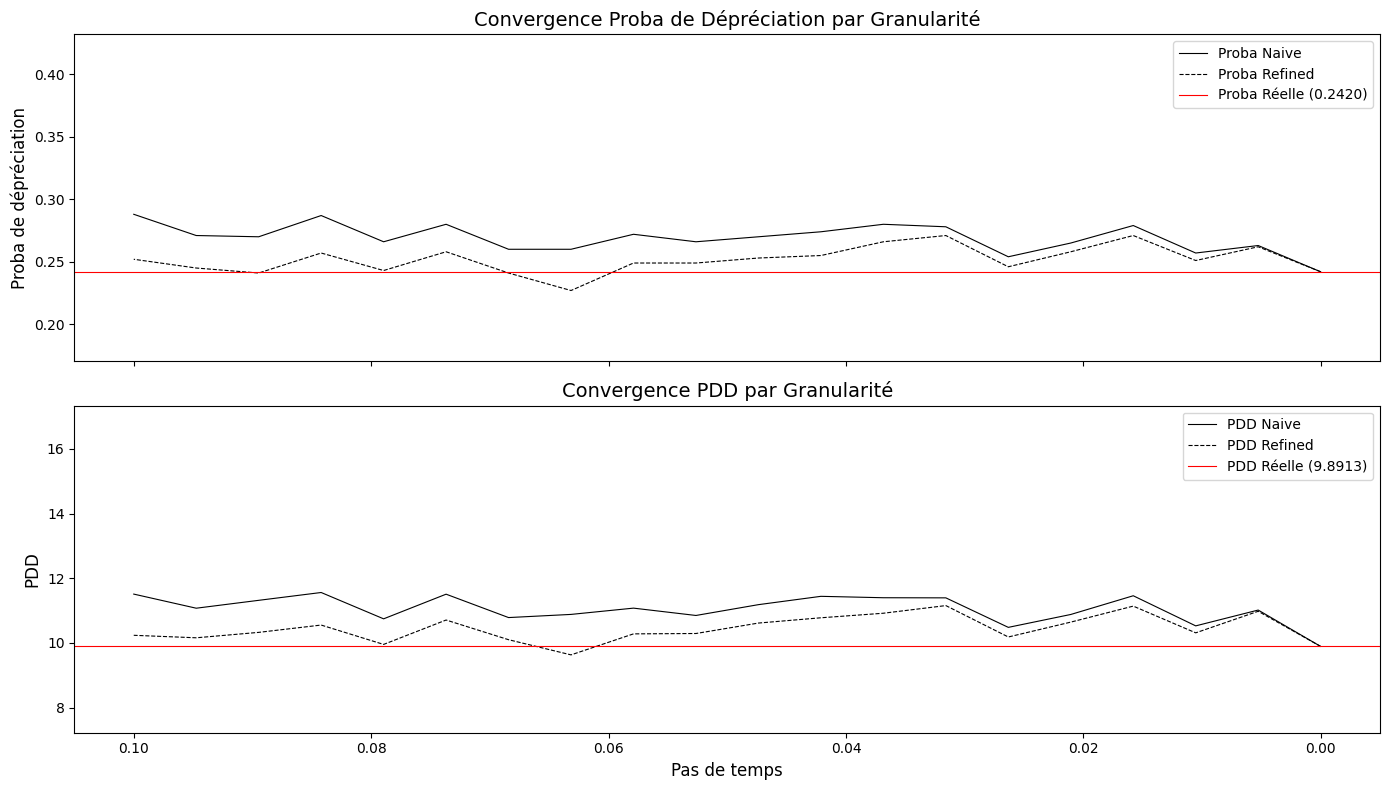

In [357]:
# ====================== Comparaison évaluation naïve et raffinée en fonction du pas de discrétisation ====================== #

N_fixed = 1000  # Nombre de scénarios pour le premier graphe

# 1er graphique : PDD vs dt (Pas de temps)
dt_values = np.linspace(0.00001, 0.1, 20)
PDD_naive_dt = []
PDD_refined_dt = []
proba_naive_dt = []
proba_refined_dt = []

# Initialisation des valeurs réelles
PDD_real = None
proba_real = None

# Boucle unique pour calculer toutes les valeurs
for i, dt in enumerate(dt_values):
    steps = int(T / dt)
    _, PDD_naive, PDD_refined, prob_naive, prob_refined = simulate_multiple_trajectories_one_period_refined(
        N_fixed, S0, r, sigma, dt, steps, Sa, alpha
    )

    # Stocker les résultats
    PDD_naive_dt.append(PDD_naive)
    PDD_refined_dt.append(PDD_refined)
    proba_naive_dt.append(prob_naive)
    proba_refined_dt.append(prob_refined)

    # Définir les valeurs réelles (calculées avec le pas de temps le plus fin)
    if i == 0:  # Premier dt correspond au plus fin
        PDD_real = round(PDD_refined, 4)
        proba_real = round(prob_refined, 4)

# J'augmente l'axe pour que visuellement on ai l'air d'avoir une meilleure convergence
y_min_pdd = min(min(PDD_naive_dt), min(PDD_refined_dt)) * 0.75
y_max_pdd = max(max(PDD_naive_dt), max(PDD_refined_dt)) * 1.5

y_min_proba = min(min(proba_naive_dt), min(proba_refined_dt)) * 0.75
y_max_proba = max(max(proba_naive_dt), max(proba_refined_dt)) * 1.5

# Création du subplot
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Graphique 1 : Proba vs dt
axs[0].plot(dt_values, proba_naive_dt, color='black', linewidth=0.8, label="Proba Naive")
axs[0].plot(dt_values, proba_refined_dt, color='black', linestyle='--', linewidth=0.8, label="Proba Refined")
axs[0].axhline(y=proba_real, color='red', linestyle='-', linewidth=0.8, label=f"Proba Réelle ({proba_real:.4f})")
axs[0].invert_xaxis()  # Inversion de l'axe des abscisses (dt)
axs[0].set_title("Convergence Proba de Dépréciation par Granularité", fontsize=14)
axs[0].set_ylabel("Proba de dépréciation", fontsize=12)
axs[0].set_ylim([y_min_proba, y_max_proba])  # Ajustement de l'échelle des ordonnées
axs[0].legend(fontsize=10)

# Graphique 2 : PDD vs dt
axs[1].plot(dt_values, PDD_naive_dt, color='black', linewidth=0.8, label="PDD Naive")
axs[1].plot(dt_values, PDD_refined_dt, color='black', linestyle='--', linewidth=0.8, label="PDD Refined")
axs[1].axhline(y=PDD_real, color='red', linestyle='-', linewidth=0.8, label=f"PDD Réelle ({PDD_real:.4f})")
axs[1].set_title("Convergence PDD par Granularité", fontsize=14)
axs[1].set_xlabel("Pas de temps", fontsize=12)
axs[1].set_ylabel("PDD", fontsize=12)
axs[1].set_ylim([y_min_pdd, y_max_pdd])  # Ajustement de l'échelle des ordonnées
axs[1].legend(fontsize=10)

# Ajustement et affichage
plt.tight_layout()
plt.savefig("convergence_PDD.png", dpi=300, bbox_inches="tight")
plt.show()

**Remarque et interprétation :** Le résultat est relativement prévisible, plus le pas de temps augmente, plus la méthode naïve tend à surévaluer la PDD, certain franchissement de barrières se sont pas détectés.

<a id='2'></a>

# 2. Un seul actif et plusieurs périodes

<a id="2_1"></a>
## 2.1 Méthode naïve

In [953]:
# ====================== Simulation 1 trajectoire naïve pour T périodes ====================== #

def simulate_trajectory_multiple_periods_naive(S0, r, sigma, T, dt):
    """
    Simule les trajectoires pour un actif sur T périodes, avec un pas de temps dt, en appliquant une méthode naïve.
    
    Arguments :
    - S0 : Prix initial de l'actif.
    - r : Taux sans risque.
    - sigma : Volatilité de l'actif.
    - T : Nombre total de périodes.
    - dt : Pas de temps pour la discrétisation.
    
    Retourne :
    - trajectory : Matrice des trajectoires simulées (par pas de temps et par période).
    - trajectory_1d : Trajectoire aplatie en une seule dimension (toutes les périodes concaténées).
    - all_lambda : Pénalités (\(\lambda\)) calculées pour chaque période.
    - vec_active : Matrice des dépassements de barrière \(S_a\) par pas de temps et par période.
    - bool_active : Tableau booléen indiquant si la barrière \(S_a\) a été dépassée pour chaque période.
    """

    # Nombre de pas par période
    steps_per_period = int(1 / dt)
    
    # Dimensions de la matrice des trajectoires et des variables associées
    dim = (steps_per_period + 1, T)  # (nombre de pas + 1, nombre de périodes)

    # Génère les incréments Brownien pour toutes les périodes et tous les pas
    Z = np.random.normal(0, 1, size=dim)  # Matrice des incréments Brownien
    vec_active = np.zeros(dim)  # Suivi des dépassements de la barrière \(S_a\) par période

    # Initialisation de la trajectoire
    trajectory = np.zeros(dim)  # Matrice des trajectoires simulées

    # Liste des pénalités \(\lambda\) pour chaque période
    all_lambda = np.zeros(T)

    # Indique si la barrière \(S_a\) a été dépassée ou non pour chaque période
    bool_active = np.zeros(T, dtype=bool)

    for period in range(T):
        # Détermination de la limite dynamique pour cette période
        Omega = Sa - np.sum(all_lambda)  
        # En période 0, la limite est \(S_a\) ; pour les autres périodes, on corrige avec les pénalités accumulées

        if period == 0:
            trajectory[0, period] = S0  # Initialisation au prix initial pour la première période
        else:
            # Transition entre périodes : dernière valeur de la période précédente
            trajectory[0, period] = trajectory[-1, period - 1] * np.exp(
                (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[0, period]
            )

        for t in range(steps_per_period):
            # Évolution du prix de l'actif par schéma exponentiel (discrétisation naïve d'Euler)
            trajectory[t + 1, period] = trajectory[t, period] * np.exp(
                (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t + 1, period]
            )

            # Suivi des dépassements à partir de la moitié de la période
            if t >= steps_per_period // 2:
                vec_active[t + 1, period] = vec_active[t, period] + (trajectory[t + 1, period] > Sa)

        # Prix final de l'actif à la fin de la période
        S_T = trajectory[-1, period]

        # Vérification : la barrière \(S_a\) a-t-elle été dépassée ?
        bool_active[period] = (vec_active[-1, period] == 0)  # True si pas de dépassement

        # Calcul de la pénalité pour cette période
        lambda_period = max(
            (Omega - S_T) * (S_T <= alpha * Sa) * bool_active[period], 0
        )
        all_lambda[period] = lambda_period

    # Conversion de la trajectoire en une dimension
    trajectory_1d = trajectory.reshape(-1, order='F')

    return trajectory, trajectory_1d, all_lambda, vec_active, bool_active

In [954]:
# ====================== Simulation N trajectoire naïve sur T périodes + PDD ====================== #

def simulate_multiple_trajectories_multiple_periods_naive(N, S0, r, sigma, T, dt):
    """
    Simule plusieurs trajectoires d'un actif sur T périodes et calcule la PDD ainsi que la probabilité de dépréciation.

    Paramètres :
    - N : Nombre total de trajectoires simulées.
    - S0 : Prix initial de l'actif.
    - r : Taux sans risque.
    - sigma : Volatilité de l'actif.
    - T : Nombre total de périodes simulées.
    - dt : Pas de temps pour la discrétisation.

    Retourne :
    - PDD : Vecteur des PDD pour chaques périodes.
    - deprecation_prob : Vecteur des probabilités de dépréciation par périodes.
    """
    # Liste pour stocker toutes les trajectoires simulées
    all_trajectories = []

    # Tableau pour accumuler les pénalités \(\lambda\) sur toutes les périodes et trajectoires
    all_lambda = np.array([])

    # Tableau pour suivre la probabilité de dépréciation par période
    deprecation_prob = np.zeros(T)

    for _ in tqdm(range(N), desc="Simulation des trajectoires naïves"):  # Boucle sur le nombre de simulations
        # Simule une trajectoire unique sur plusieurs périodes
        trajectory, trajectory_1d, all_lambda_per_trajectory, vec_active, bool_active = simulate_trajectory_multiple_periods_naive(
            S0, r, sigma, T, dt
        )

        # Ajoute la trajectoire aplatie (colonne unique) à la liste des trajectoires
        all_trajectories.append(trajectory.reshape(-1, 1, order='F'))

        # Ajoute les pénalités \(\lambda\) calculées pour cette trajectoire
        all_lambda = np.concatenate((all_lambda, all_lambda_per_trajectory))

        # Récupère les valeurs finales de chaque période pour cette trajectoire
        last_value_traj = trajectory[-1, :]  # Dernier pas de temps pour chaque période

        # Met à jour la probabilité de dépréciation (barrière non franchie et prix final sous \(\alpha S_a\))
        deprecation_prob += bool_active.astype(bool) & (last_value_traj <= alpha * Sa)

    # Reshape de all_lambda pour correspondre au format (N simulations, T périodes)
    all_lambda = all_lambda.reshape(N, T)

    # Moyenne des pénalités \(\lambda\) par période
    means_all_lambda_columns = np.mean(all_lambda, axis=0)

    # PDD cumulée (somme des moyennes par période)
    PDD = np.cumsum(means_all_lambda_columns)

    # Probabilité de dépréciation par période
    deprecation_prob /= N

    return PDD, deprecation_prob

<a id="2_2"></a>
## 2.2 Méthode raffinée

In [602]:
# ====================== Simulation 1 trajectoire raffinée pour T périodes ====================== #

def simulate_trajectory_multiple_periods_refined(S0, r, sigma, T, dt):
    """
    Simule une trajectoire unique du processus de prix d'une action, en utilisant une approche raffinée
    avec probabilités intermédiaires de dépassement basées sur le pont brownien.

    Paramètres :
    - S0 : Prix initial de l'actif.
    - r : Taux sans risque.
    - sigma : Volatilité.
    - T : Nombre total de périodes simulées.
    - dt : Pas de temps.

    Retourne :
    - trajectory : Trajectoire simulée (logarithmique puis exponentielle).
    - trajectory_1d : Trajectoire aplatie en une seule dimension.
    - all_lambda_naive : Pénalité naïve associée à l'absence de dépassement.
    - all_lambda_refined : Pénalité raffinée associée à l'absence de dépassement.
    - vec_active_naive : Vecteur indiquant les dépassements naïfs.
    - vec_active_refined : Vecteur indiquant les dépassements raffinés.
    - bool_active_naive : Booléen indiquant si la barrière n'a jamais été dépassée (approche naïve).
    - bool_active_refined : Booléen indiquant si la barrière n'a jamais été dépassée (approche raffinée).
    """
    # Nombre de pas par période et dimensions des matrices
    steps_per_period = int(1 / dt)
    dim = (steps_per_period + 1, T)
    logSa = np.log(Sa)

    # Initialisations
    Z = np.random.normal(0, 1, size=(steps_per_period, T))  # Incréments brownien
    vec_active_naive = np.zeros((steps_per_period, T))
    vec_active_refined = np.zeros((steps_per_period, T))
    trajectory_log = np.zeros(dim)

    all_lambda_naive = np.zeros(T)
    all_lambda_refined = np.zeros(T)
    bool_active_naive = np.zeros(T, dtype=bool)
    bool_active_refined = np.zeros(T, dtype=bool)

    # Initialisation de la première période
    trajectory_log[0, 0] = np.log(S0)

    for period in range(T):
        if period > 0:
            # Continuité de la trajectoire entre périodes
            trajectory_log[0, period] = trajectory_log[-1, period - 1]

        # Limites corrigées pour chaque méthode
        Omega_naive = Sa - np.sum(all_lambda_naive[:period])
        Omega_refined = Sa - np.sum(all_lambda_refined[:period])

        # Simulation de la trajectoire pour la période courante
        for t in range(steps_per_period):
            trajectory_log[t + 1, period] = (
                trajectory_log[t, period]
                + (r - 0.5 * sigma**2) * dt
                + sigma * np.sqrt(dt) * Z[t, period]
            )

            if t >= steps_per_period // 2:
                # Calcul de p_k pour la méthode raffinée
                U = np.random.uniform(0, 1)
                p_k = np.exp(
                    -2
                    * (trajectory_log[t, period] - logSa)
                    * (trajectory_log[t + 1, period] - logSa)
                    / (sigma**2 * dt)
                )
                p_k = np.clip(p_k, 0, 1)

                # Mise à jour des vecteurs d'activité
                vec_active_naive[t, period] = (
                    vec_active_naive[t - 1, period]
                    + (trajectory_log[t, period] > logSa)
                )
                vec_active_refined[t, period] = (
                    vec_active_refined[t - 1, period] + (U <= p_k)
                )

        # Dernière valeur simulée pour la période
        logS_T = trajectory_log[-1, period]
        S_T = np.exp(logS_T)  # Conversion en échelle normale pour les lambdas

        # Calcul des booléens d'activité
        bool_active_naive[period] = vec_active_naive[-1, period] == 0
        bool_active_refined[period] = vec_active_refined[-1, period] == 0

        # Calcul des lambdas
        lambda_naive = max(
            (Omega_naive - S_T) * (S_T <= alpha * Sa) * bool_active_naive[period], 0
        )
        lambda_refined = max(
            (Omega_refined - S_T) * (S_T <= alpha * Sa) * bool_active_refined[period], 0
        )

        all_lambda_naive[period] = lambda_naive
        all_lambda_refined[period] = lambda_refined

    # Conversion des trajectoires logarithmiques en échelle normale
    trajectory = np.exp(trajectory_log)
    trajectory_1d = trajectory.reshape(-1, order="F")

    return (
        trajectory,
        trajectory_1d,
        all_lambda_naive,
        all_lambda_refined,
        vec_active_naive,
        vec_active_refined,
        bool_active_naive,
        bool_active_refined,
    )

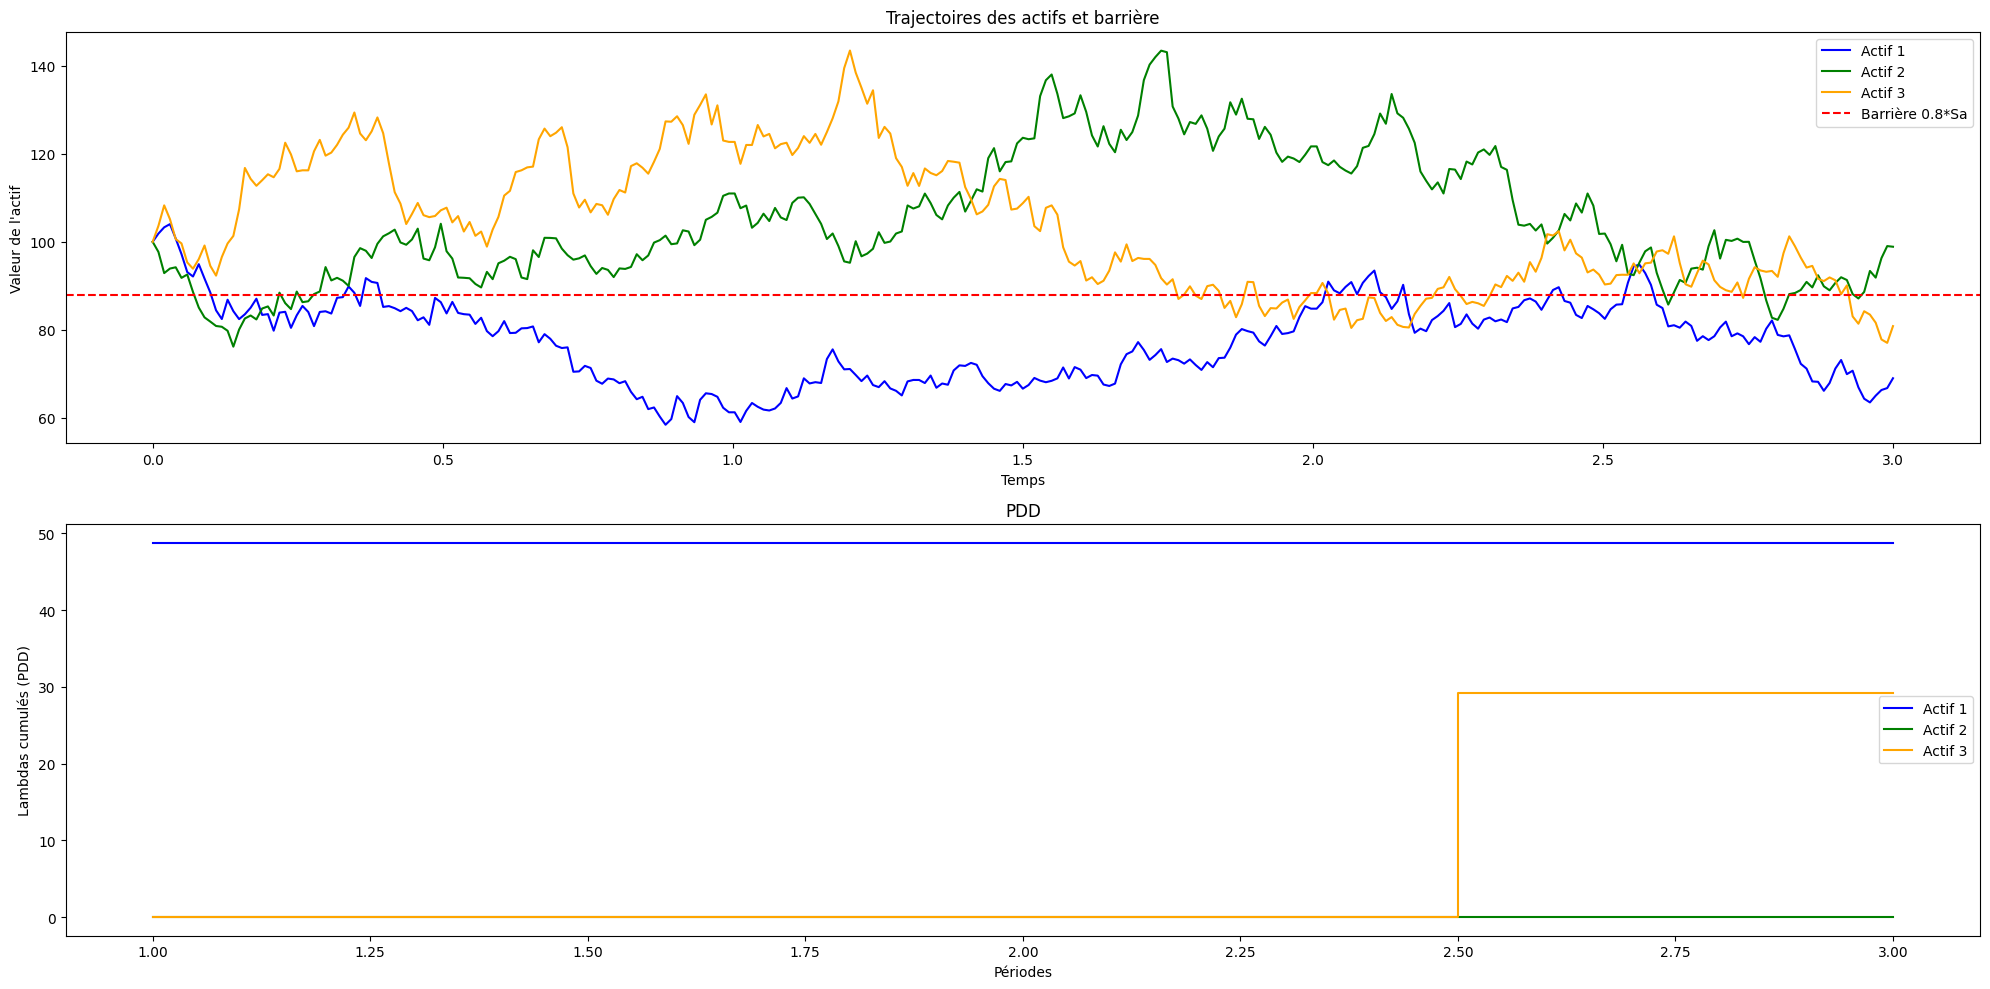

In [361]:
# ====================== Test simulation ====================== #

S0 = 100  # Prix initial de l'actif
Sa = 110  # Barrière
r = 0.02  # Taux sans risque
sigma = 0.3  # Volatilité
T = 3  # Nombre total de périodes simulées
dt = 0.01  # Pas de temps
alpha = 0.8  # Facteur pour la barrière
colors = ['blue', 'green', 'orange']  # Couleurs pour les 3 actifs

# ====================== Simulation des trajectoires et lambdas ====================== #
trajectories = []
lambdas_cumulated = []

for n in range(3):
    # Appel de votre fonction
    (
        trajectory,
        trajectory_1d,
        all_lambda_naive,
        all_lambda_refined,
        vec_active_naive,
        vec_active_refined,
        bool_active_naive,
        bool_active_refined,
    ) = simulate_trajectory_multiple_periods_refined(S0, r, sigma, T, dt)
    
    # Stocker la trajectoire et les lambdas cumulés naïfs
    trajectories.append(trajectory_1d)
    lambdas_cumulated.append(np.cumsum(all_lambda_naive))

# ====================== Tracé des graphiques ====================== #
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Subplot 1 : Trajectoires des actifs avec la barrière
time_steps = np.linspace(0, T, len(trajectories[0]))
for i, trajectory in enumerate(trajectories):
    axs[0].plot(time_steps, trajectory, label=f'Actif {i+1}', color=colors[i])
axs[0].axhline(alpha * Sa, color='red', linestyle='--', label='Barrière 0.8*Sa')
axs[0].set_title("Trajectoires des actifs et barrière")
axs[0].set_xlabel("Temps")
axs[0].set_ylabel("Valeur de l'actif")
axs[0].legend()

# Subplot 2 : Lambdas cumulés
periods = np.arange(1, T + 1)
for i, lambdas in enumerate(lambdas_cumulated):
    axs[1].step(periods, lambdas, label=f'Actif {i+1}', color=colors[i], where='mid')
axs[1].set_title("PDD")
axs[1].set_xlabel("Périodes")
axs[1].set_ylabel("Lambdas cumulés (PDD)")
axs[1].legend()

# Ajustement et affichage
plt.tight_layout()
plt.savefig("test_simul.png", dpi=300, bbox_inches="tight")
plt.show()

In [603]:
# ====================== Simulation N trajectoires raffinées sur T périodes + PDD ====================== #

def simulate_multiple_trajectories_multiple_periods_refined(N, S0, r, sigma, T, dt):
    """
    Simule N trajectoires du processus de prix d'une action sur plusieurs périodes en utilisant la méthode raffinée
    et calcule les métriques associées.

    Arguments :
    - N : Nombre total de trajectoires simulées.
    - S0 : Prix initial de l'actif.
    - r : Taux sans risque.
    - sigma : Volatilité.
    - T : Nombre total de périodes simulées.
    - dt : Pas de temps pour la discrétisation.
    
    Retourne :
    - all_trajectories : Liste de toutes les trajectoires simulées (aplaties).
    - PDD_naive : Vecteur des PDD naïves (cumulées par période).
    - PDD_refined : Vecteur des PDD raffinées (cumulées par période).
    - depreciation_prob_naive : Vecteur des probabilités de dépréciation (méthode naïve).
    - depreciation_prob_refined : Vecteur des probabilités de dépréciation (méthode raffinée).
    """
    # Initialisations des accumulateurs
    all_trajectories = []
    all_lambda_naive = np.array([])
    all_lambda_refined = np.array([])
    depreciation_prob_naive = np.zeros(T)
    depreciation_prob_refined = np.zeros(T)

    for _ in tqdm(range(N), desc="Simulation raffinée des trajectoires"):
        # Simule une trajectoire unique sur T périodes
        (
            trajectory,
            trajectory_1d,
            all_lambda_naive_per_trajectory,
            all_lambda_refined_per_trajectory,
            vec_active_naive,
            vec_active_refined,
            bool_active_naive,
            bool_active_refined,
        ) = simulate_trajectory_multiple_periods_refined(S0, r, sigma, T, dt)

        # Stockage des trajectoires
        all_trajectories.append(trajectory_1d)

        # Accumulation des pénalités lambda pour chaque méthode
        all_lambda_naive = np.concatenate((all_lambda_naive, all_lambda_naive_per_trajectory))
        all_lambda_refined = np.concatenate((all_lambda_refined, all_lambda_refined_per_trajectory))

        # Dernières valeurs de la trajectoire pour la période en cours
        last_value_traj = trajectory[-1, :]

        # Mise à jour des probabilités de dépréciation
        depreciation_prob_naive += (
            bool_active_naive.astype(bool) & (last_value_traj <= alpha * Sa)
        )
        depreciation_prob_refined += (
            bool_active_refined.astype(bool) & (last_value_traj <= alpha * Sa)
        )

    # Reshape des pénalités lambda pour correspondre à (N simulations, T périodes)
    all_lambda_naive = all_lambda_naive.reshape(N, T)
    all_lambda_refined = all_lambda_refined.reshape(N, T)

    # Moyennes par colonne pour chaque méthode
    means_all_lambda_columns_naive = np.mean(all_lambda_naive, axis=0)
    means_all_lambda_columns_refined = np.mean(all_lambda_refined, axis=0)

    # Calcul des PDD cumulées
    PDD_naive = np.cumsum(means_all_lambda_columns_naive)
    PDD_refined = np.cumsum(means_all_lambda_columns_refined)

    # Calcul des probabilités de dépréciation moyennes
    depreciation_prob_naive /= N
    depreciation_prob_refined /= N

    return all_trajectories, PDD_naive, PDD_refined, depreciation_prob_naive, depreciation_prob_refined

Simulation raffinée des trajectoires: 100%|██████████| 1000/1000 [00:01<00:00, 669.79it/s]


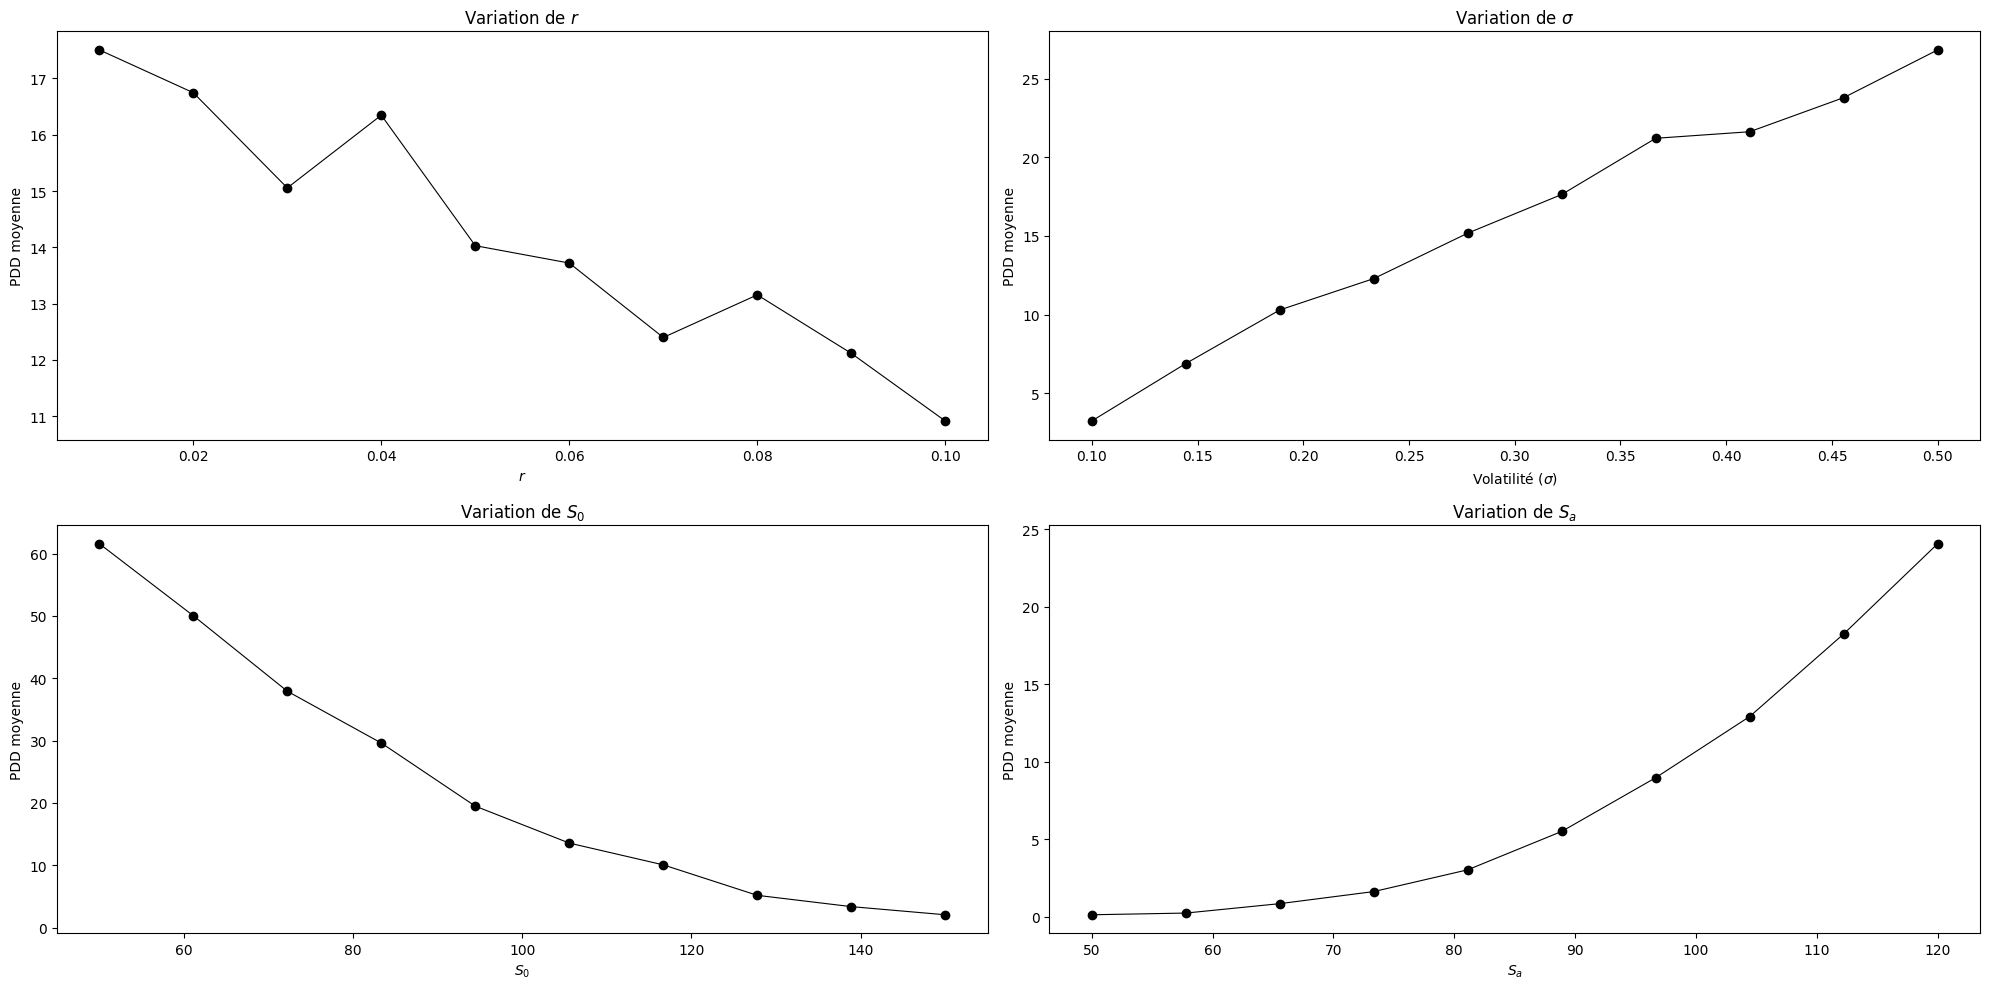

In [363]:
# ====================== Variation des paramètres  ====================== #

# Plages de valeurs pour les paramètres
r_values = np.linspace(0.01, 0.1, 10)
sigma_values = np.linspace(0.1, 0.5, 10)
S0_values = np.linspace(50, 150, 10)
Sa_values = np.linspace(50, 120, 10)

# Paramètres fixes
S0 = 100
Sa = 110
r = 0.02
sigma = 0.3
N = 1000    # Nombre de simulations
dt = 0.01  # Pas de temps
T = 2

# Subplot 1: Variation de r
PDD_r = []
for r_var in r_values:
    _, PDD_naive, _, _, _ = simulate_multiple_trajectories_multiple_periods_refined(N, S0, r_var, sigma, T, dt)
    PDD_r.append(PDD_naive.mean())

# Subplot 2: Variation de sigma
PDD_sigma = []
for sigma_var in sigma_values:
    _, PDD_naive, _, _, _ = simulate_multiple_trajectories_multiple_periods_refined(N, S0, r, sigma_var, T, dt)
    PDD_sigma.append(PDD_naive.mean())

# Subplot 3: Variation de S0
PDD_S0 = []
for S0_var in S0_values:
    _, PDD_naive, _, _, _ = simulate_multiple_trajectories_multiple_periods_refined(N, S0_var, r, sigma, T, dt)
    PDD_S0.append(PDD_naive.mean())

# Subplot 4: Variation de Sa
PDD_Sa = []
for Sa_var in Sa_values:
    Sa = Sa_var
    _, PDD_naive, _, _, _ = simulate_multiple_trajectories_multiple_periods_refined(N, S0, r, sigma, T, dt)
    PDD_Sa.append(PDD_naive.mean())

# ====================== Tracé des subplots ====================== #
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Subplot 1: Variation de r
axs[0, 0].plot(r_values, PDD_r, marker='o', color='black', linestyle='-', linewidth=0.8)
axs[0, 0].set_title("Variation de $r$")
axs[0, 0].set_xlabel("$r$")
axs[0, 0].set_ylabel("PDD moyenne")

# Subplot 2: Variation de sigma
axs[0, 1].plot(sigma_values, PDD_sigma, marker='o', color='black', linestyle='-', linewidth=0.8)
axs[0, 1].set_title("Variation de $\sigma$")
axs[0, 1].set_xlabel("Volatilité ($\sigma$)")
axs[0, 1].set_ylabel("PDD moyenne")

# Subplot 3: Variation de S0
axs[1, 0].plot(S0_values, PDD_S0, marker='o', color='black', linestyle='-', linewidth=0.8)
axs[1, 0].set_title("Variation de $S_0$")
axs[1, 0].set_xlabel("$S_0$")
axs[1, 0].set_ylabel("PDD moyenne")

# Subplot 4: Variation de Sa
axs[1, 1].plot(Sa_values, PDD_Sa, marker='o', color='black', linestyle='-', linewidth=0.8)
axs[1, 1].set_title("Variation de $S_a$")
axs[1, 1].set_xlabel("$S_a$")
axs[1, 1].set_ylabel("PDD moyenne")

Sa = 110  # Pour la suite du code

# Ajustement et affichage
plt.tight_layout()

plt.savefig("variation_params.png", dpi=300, bbox_inches="tight")
plt.show()

In [522]:
# ====================== Résultats PDD naïve + raffinée ====================== #

N = 1000    # Nombre de simulations
dt = 0.01  # Pas de temps
T = 10      # Durée de la période

_, PDD_naive, PDD_refined, depreciation_prob_naive, depreciation_prob_refined = simulate_multiple_trajectories_multiple_periods_refined(N, S0, r, sigma, T, dt)

# Affichage amélioré des résultats
print("=" * 50)
print("\nRésultats pour chaque période :\n")
print("=" * 50)
print(f"Nombre de simulations (N)                : {N}")
print(f"Durée de la période (T)                  : {T} an(s)")
print(f"Pas de temps (dt)                        : {dt:.6f} an(s)")
print(f"Nombre de pas dans la discrétisation     : {steps}")
print("-" * 50)
for t in range(T):
    print(f"PDD_{t} naive : {PDD_naive[t]:.4f}")
    print(f"PDD_{t} raffinée : {PDD_refined[t]:.4f}")
    print("\n-------------------------------------------")

Simulation raffinée des trajectoires: 100%|██████████| 1000/1000 [00:05<00:00, 194.67it/s]


Résultats pour chaque période :

Nombre de simulations (N)                : 1000
Durée de la période (T)                  : 10 an(s)
Pas de temps (dt)                        : 0.010000 an(s)
Nombre de pas dans la discrétisation     : 100
--------------------------------------------------
PDD_0 naive : 11.8845
PDD_0 raffinée : 11.7242

-------------------------------------------
PDD_1 naive : 20.9408
PDD_1 raffinée : 20.8740

-------------------------------------------
PDD_2 naive : 26.9444
PDD_2 raffinée : 26.8716

-------------------------------------------
PDD_3 naive : 31.8216
PDD_3 raffinée : 31.7089

-------------------------------------------
PDD_4 naive : 35.8313
PDD_4 raffinée : 35.7300

-------------------------------------------
PDD_5 naive : 40.1248
PDD_5 raffinée : 40.0138

-------------------------------------------
PDD_6 naive : 43.5816
PDD_6 raffinée : 43.4094

-------------------------------------------
PDD_7 naive : 46.2625
PDD_7 raffinée : 46.2258

------------------

Simulation raffinée des trajectoires:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation raffinée des trajectoires: 100%|██████████| 1000/1000 [00:05<00:00, 189.53it/s]


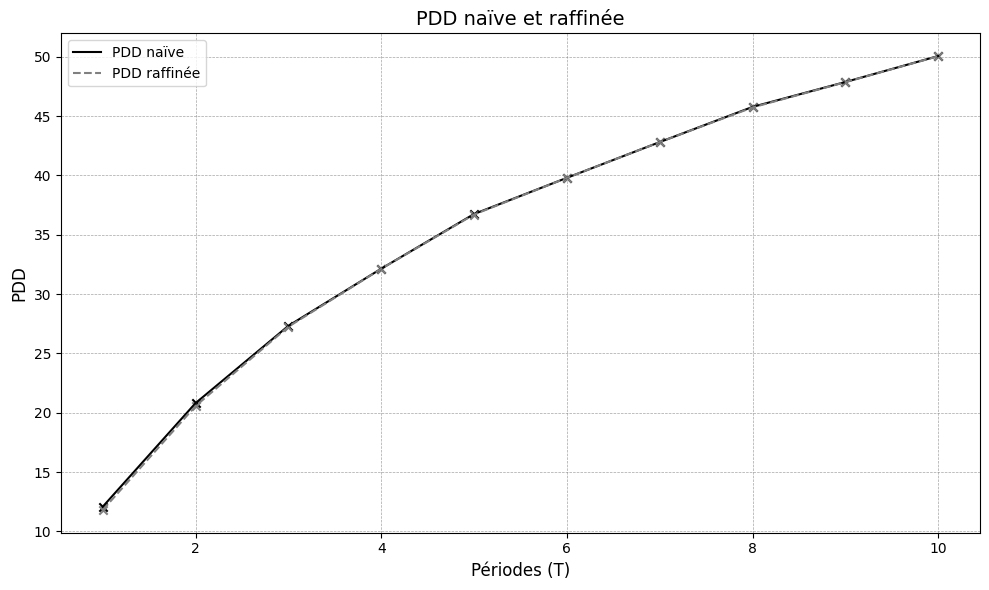

In [523]:
# ====================== Résultats PDD naïve + raffinée ====================== #

N = 1000    # Nombre de simulations
dt = 0.01   # Pas de temps
T = 10      # Durée de la période

_, PDD_naive, PDD_refined, depreciation_prob_naive, depreciation_prob_refined = simulate_multiple_trajectories_multiple_periods_refined(N, S0, r, sigma, T, dt)

# Tracé du graphique
plt.figure(figsize=(10, 6))

# Axe x pour le nombre de périodes
periods = np.arange(1, T + 1)

# Tracé des deux courbes avec croix sur les points
plt.plot(periods, PDD_naive, color='black', linestyle='-', label='PDD naïve')
plt.scatter(periods, PDD_naive, color='black', marker='x')  # Points pour PDD naïve

plt.plot(periods, PDD_refined, color='gray', linestyle='--', label='PDD raffinée')
plt.scatter(periods, PDD_refined, color='gray', marker='x')  # Points pour PDD raffinée

# Ajout des labels et titre
plt.title("PDD naïve et raffinée", fontsize=14)
plt.xlabel("Périodes (T)", fontsize=12)
plt.ylabel("PDD", fontsize=12)

# Ajout de la légende
plt.legend(fontsize=10, loc="upper left")

# Grille légère pour lisibilité
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Affichage du graphique
plt.tight_layout()
plt.savefig("evolution_T.png", dpi=300, bbox_inches="tight")
plt.show()

<a id="2_3"></a>
## 2.3 Comparaison des méthodes (Plotly : graphe non visible (voir rapport))

Comme nous avons vu précédemment, la méthode naïve a tendance à surévaluer la PDD. Une mesure intéressante pour comparer l'erreur comise par la version naïve serai d'estimer :

$$
\Delta = PDD_{\text{naïve}} - PDD_{\text{raffinée}}
$$


In [366]:
# ====================== Etude de l'erreur naïve ====================== #

# Paramètres globaux
N = 1000           # Nombre de simulations
T_max = 10         # Nombre maximum de périodes
dt_values = np.linspace(0.01, 0.1, 10)       # Pas de temps croissants
T_values = np.arange(1, T_max + 1)           # Périodes (1 à T_max)

# Matrice pour stocker les différences PDD_naive - PDD_refined
delta_PDD = np.zeros((len(dt_values), len(T_values)))

# Génération des données
for i, dt in enumerate(dt_values):
    for j, T in enumerate(T_values):
        # Simule les trajectoires pour un T et un dt donnés
        _, PDD_naive, PDD_refined, _, _ = simulate_multiple_trajectories_multiple_periods_refined(
            N, S0, r, sigma, T, dt
        )
        # Stocke la différence PDD_naive - PDD_refined pour la période finale
        delta_PDD[i, j] = PDD_naive[-1] - PDD_refined[-1]

# Appliquer un filtre gaussien pour lisser les variations
delta_PDD_smooth = gaussian_filter(delta_PDD, sigma=1)

# Création de la grille pour le graphique 3D
T_grid, dt_grid = np.meshgrid(T_values, dt_values)

# Création du graphique avec Plotly
fig = go.Figure()

# Ajout de la surface interpolée
fig.add_trace(go.Surface(
    z=delta_PDD_smooth,
    x=T_values,   # Axe x : T
    y=dt_values,  # Axe y : dt
    colorscale='Viridis',
    showscale=True,
    opacity=0.9,  # Opacité de la surface
    colorbar=dict(title="Erreur provision")  # Légende de la barre des couleurs
))

# Mise en page
fig.update_layout(
    scene=dict(
        xaxis_title="Nombre de périodes (T)",
        yaxis_title="Pas de temps (dt)",
        zaxis_title=r"PDD naïve - PDD raffinée",
        xaxis=dict(showgrid=True),  # Quadrillage activé pour les axes
        yaxis=dict(showgrid=True),
        zaxis=dict(showgrid=True)
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    width=800,  # Largeur de la figure pour une taille compacte
    height=600  # Hauteur de la figure pour une taille carrée
)

# Affichage interactif
fig.show()

Simulation raffinée des trajectoires:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation raffinée des trajectoires: 100%|██████████| 1000/1000 [00:00<00:00, 1414.23it/s]


**Remarque :** La forte variance des estimations rend le graphe difficile à interpréter. Nous avons donc utilisé la fonction **gaussian_filter** pour filtrer le bruit et permettre une interprétation plus précise.

Le résultat de ce graphique est contre-intuitif et particulièrement intéressant. On observe que l'erreur de prédiction de la méthode naïve augmente avec le pas de temps (comme dans la première partie), mais qu'elle diminue avec le nombre de périodes T.

Ce comportement peut s'expliquer : plus l'actif est projeté sur un horizon temporel lointain, plus sa distribution s'étale (variance plus élevée), plus il y a de chance qu'il s'éloigne de la barrière, ce qui réduit la fréquence des erreurs dues à la discrétisation.

<a id="2_4"></a>
## 2.4 Choc des paramètres $\sigma$ et $r$ (Plotly : graphe non visible (voir rapport))

### 2.4.1 Choc pour $T = 1$

In [367]:
# ====================== Choc des paramètres T = 1 ====================== #

# Paramètres globaux
N = 1000           # Nombre de simulations
T = 1              # Bloquer le nombre de périodes à 1
sigma_values = np.linspace(0.1, 1.0, 10)  # Plage de volatilités
r_values = np.linspace(0.01, 0.1, 10)     # Plage de taux sans risque

# Matrice pour stocker les PDD raffinées
PDD_refined_matrix = np.zeros((len(r_values), len(sigma_values)))

# Génération des données
for i, r in enumerate(r_values):
    for j, sigma in enumerate(sigma_values):
        # Simule les trajectoires pour un sigma et un r donnés
        _, _, PDD_refined, _, _ = simulate_multiple_trajectories_multiple_periods_refined(
            N, S0, r, sigma, T, dt=0.01
        )
        # Stocke la PDD raffinée pour la période finale
        PDD_refined_matrix[i, j] = PDD_refined[-1]

# Création de la grille pour le graphique 3D
sigma_grid, r_grid = np.meshgrid(sigma_values, r_values)

# Création des subplots : 1 ligne, 2 colonnes
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Surface 3D", "Heatmap"),
    specs=[[{'type': 'surface'}, {'type': 'heatmap'}]]
)

# Ajout de la surface interpolée (subplot 1)
fig.add_trace(
    go.Surface(
        z=PDD_refined_matrix,
        x=sigma_values,   # Axe x : Volatilité (σ)
        y=r_values,       # Axe y : Taux sans risque (r)
        colorscale='Viridis',
        showscale=False,  # Ne pas afficher la barre des couleurs pour éviter la redondance
        opacity=0.9       # Opacité de la surface
    ),
    row=1, col=1
)

# Ajout de la heatmap (subplot 2)
fig.add_trace(
    go.Heatmap(
        z=PDD_refined_matrix,
        x=sigma_values,   # Axe x : Volatilité (σ)
        y=r_values,       # Axe y : Taux sans risque (r)
        colorscale='Viridis',
        colorbar=dict(title="PDD")  # Légende de la barre des couleurs
    ),
    row=1, col=2
)

# Mise en page
fig.update_layout(
    scene=dict(
        xaxis_title="Volatilité (σ)",
        yaxis_title="Taux sans risque (r)",
        zaxis_title="Montant PDD",
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=1200,  # Largeur totale pour inclure les deux subplots
    height=500   # Hauteur uniforme
)

# Mise à jour des axes de la heatmap
fig.update_xaxes(title_text="Volatilité (σ)", row=1, col=2)
fig.update_yaxes(title_text="Taux sans risque (r)", row=1, col=2)

# Affichage interactif
fig.show()

Simulation raffinée des trajectoires: 100%|██████████| 1000/1000 [00:00<00:00, 1890.91it/s]


### 2.4.2 Choc pour $T = 10$

In [368]:
# ====================== Choc des paramètres T = 10 ====================== #

# Paramètres globaux
N = 1000           # Nombre de simulations
T = 10              # Bloquer le nombre de périodes à 1
sigma_values = np.linspace(0.1, 1.0, 10)  # Plage de volatilités
r_values = np.linspace(0.01, 0.1, 10)     # Plage de taux sans risque

# Matrice pour stocker les PDD raffinées
PDD_refined_matrix = np.zeros((len(r_values), len(sigma_values)))

# Génération des données
for i, r in enumerate(r_values):
    for j, sigma in enumerate(sigma_values):
        # Simule les trajectoires pour un sigma et un r donnés
        _, _, PDD_refined, _, _ = simulate_multiple_trajectories_multiple_periods_refined(
            N, S0, r, sigma, T, dt=0.01
        )
        # Stocke la PDD raffinée pour la période finale
        PDD_refined_matrix[i, j] = PDD_refined[-1]

# Création de la grille pour le graphique 3D
sigma_grid, r_grid = np.meshgrid(sigma_values, r_values)

# Création des subplots : 1 ligne, 2 colonnes
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Surface 3D", "Heatmap"),
    specs=[[{'type': 'surface'}, {'type': 'heatmap'}]]
)

# Ajout de la surface interpolée (subplot 1)
fig.add_trace(
    go.Surface(
        z=PDD_refined_matrix,
        x=sigma_values,   # Axe x : Volatilité (σ)
        y=r_values,       # Axe y : Taux sans risque (r)
        colorscale='Viridis',
        showscale=False,  # Ne pas afficher la barre des couleurs pour éviter la redondance
        opacity=0.9       # Opacité de la surface
    ),
    row=1, col=1
)

# Ajout de la heatmap (subplot 2)
fig.add_trace(
    go.Heatmap(
        z=PDD_refined_matrix,
        x=sigma_values,   # Axe x : Volatilité (σ)
        y=r_values,       # Axe y : Taux sans risque (r)
        colorscale='Viridis',
        colorbar=dict(title="PDD")  # Légende de la barre des couleurs
    ),
    row=1, col=2
)

# Mise en page
fig.update_layout(
    scene=dict(
        xaxis_title="Volatilité (σ)",
        yaxis_title="Taux sans risque (r)",
        zaxis_title="Montant PDD",
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=1200,  # Largeur totale pour inclure les deux subplots
    height=500   # Hauteur uniforme
)

# Mise à jour des axes de la heatmap
fig.update_xaxes(title_text="Volatilité (σ)", row=1, col=2)
fig.update_yaxes(title_text="Taux sans risque (r)", row=1, col=2)

# Affichage interactif
fig.show()

Simulation raffinée des trajectoires: 100%|██████████| 1000/1000 [00:03<00:00, 322.62it/s]


**Remarque :** On apperçois les mêmes phénomènes dans les deux cas.

On observe que le paramètre $r$ est très légèrement **inversement proportionnel** à la PDD. 
Cette relation est cohérente : sous la probabilité risque neutre $\mathbb{Q}$, les actifs ont un rendement moyen 
espéré égal au taux sans risque. Ainsi, plus le taux sans risque $r$ augmente, plus l'espérance des actifs s’accroît. 
Par conséquent, les probabilités d’observer une dépréciation diminuent.

En revanche, la relation avec la volatilité $\sigma$ est beaucoup plus marquée. Plus la volatilité d’un actif est élevée, 
plus sa distribution est étalée, ce qui augmente la densité de probabilité sous la barrière, entraînant une probabilité de dépréciation plus élevée.


<a id="2_5"></a>
## 2.5 Sensibilité de la PDD, les grecques :

Nous allons estimer les quantités suivantes par différences finies :
$$\text{Vega} = \frac{\partial}{\partial \sigma} \mathbb{E}_\mathbb{Q} \left[ \lambda_0(r, \sigma, S_a, S_0) \right], \quad
\text{Rho} = \frac{\partial}{\partial r} \mathbb{E}_\mathbb{Q} \left[ \lambda_0(r, \sigma, S_a, S_0) \right], \quad
\text{Delta} = \frac{\partial}{\partial S_0} \mathbb{E}_\mathbb{Q} \left[ \lambda_0(r, \sigma, S_a, S_0) \right]$$



Pour un paramètre $x$ (tel que $r$, $\sigma$, ou $S_0$), la sensibilité est donnée par la dérivée partielle :  
$$
\frac{\partial \text{PDD}}{\partial x}
$$

Comme la PDD est une fonction calculée numériquement, cette dérivée est approximée par les différences finies. On distingue deux méthodes principales :

1. Les différences finies avant (forward differences) :  

$$
\frac{\partial \text{PDD}}{\partial x} \approx \frac{\text{PDD}(x + h) - \text{PDD}(x)}{h}
$$

2. Les différences finies centrées (central differences), qui réduisent la variance de l'estimateur précédent:  

$$
\frac{\partial \text{PDD}}{\partial x} \approx \frac{\text{PDD}(x + h) - \text{PDD}(x - h)}{2h}
$$


Le choix de $h$ est crucial. Il est nécessaire que $h$ soit suffisamment petit pour approcher une variation infinitésimale, cependant pour une variation trop petite, notre estimateur risque de capter les variations de l'estimateur PDD et non les variations liées à la variable étudiée.

Pour chaque paramètre $x \in \{r, \sigma, S_0\}$, les étapes sont les suivantes :  
Simuler la PDD pour une valeur de référence $x$. Ensuite, modifier $x$ de $+h$ et de $-h$, et recalculer la PDD pour ces nouvelles valeurs. Finalement, appliquer les différences finies centrées :  

$$
\frac{\partial \text{PDD}}{\partial x} \approx \frac{\text{PDD}(x + h) - \text{PDD}(x - h)}{2h}
$$

Cette analyse est répétée pour une plage de valeurs de $x$ afin de comprendre l'évolution de la sensibilité.  

### 2.5.1 Vega

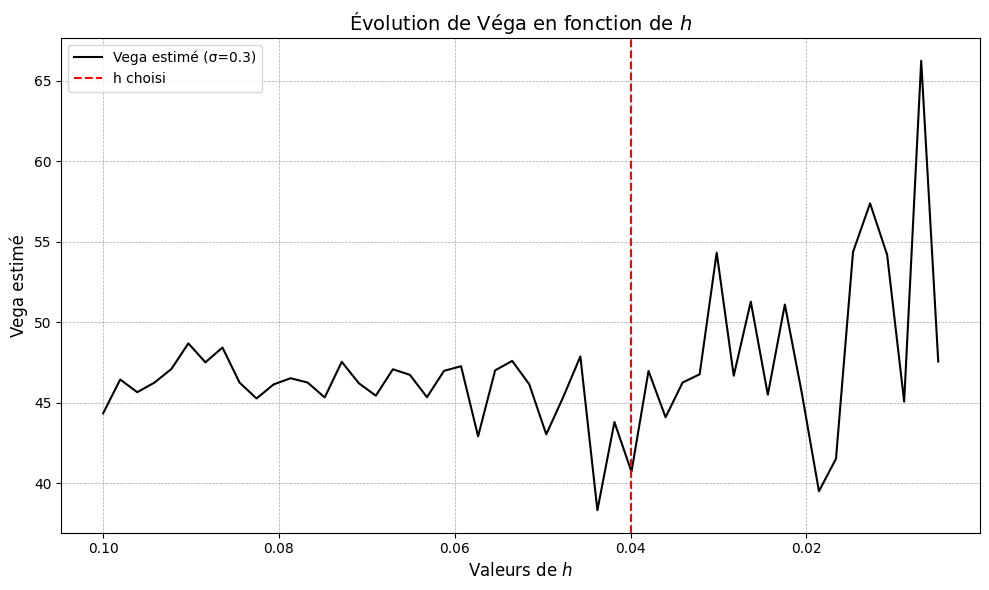

In [369]:
# ====================== Recherche d'une valeur de h ====================== #

S0 = 100
Sa = 110
N = 100
dt = 0.01
T = 1
r = 0.02
sigma = 0.3  # Volatilité
alpha = 0.75
steps = int(1 / dt)

# Fonction pour l'estimation du Vega
def Vega_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats):
    """
    Calcule la grecque Vega avec une méthode de différence finies et par itérations monte carlo.

    Arguments :
    - N : Nombre total de trajectoires simulées.
    - num_repeats : Nombre itération pour le calcul de la grecque
    - S0 : Prix initial de l'actif.
    - r : Taux sans risque.
    - sigma : Volatilité.
    - T : Nombre total de périodes simulées.
    - dt : Pas de temps pour la discrétisation.
    
    Retourne :
    - Vega : Moyenne de la grecque pour chaque scénarios num_repeats.
    """
    PDD_sigma_vals = []
    PDD_sigma_plus_vals = []
    PDD_sigma_minus_vals = []

    sigma_plus = sigma + h
    sigma_minus = sigma - h

    for _ in range(num_repeats):
        PDD_sigma = simulate_multiple_trajectories_one_period(N, S0, r, sigma, dt, steps, Sa, alpha)[1]
        PDD_sigma_plus = simulate_multiple_trajectories_one_period(N, S0, r, sigma_plus, dt, steps, Sa, alpha)[1]
        PDD_sigma_minus = simulate_multiple_trajectories_one_period(N, S0, r, sigma_minus, dt, steps, Sa, alpha)[1]
        PDD_sigma_vals.append(PDD_sigma)
        PDD_sigma_plus_vals.append(PDD_sigma_plus)
        PDD_sigma_minus_vals.append(PDD_sigma_minus)

    Vega = np.mean((np.array(PDD_sigma_plus_vals) - np.array(PDD_sigma_minus_vals)) / (2 * h))
    return Vega

# ====================== Exploration des valeurs de h ====================== #
num_repeats = 100  # Fixer le nombre d'itérations Monte Carlo
h_values = np.linspace(0.005, 0.1, 50)  # Plage des valeurs de h
Vega_values = []

# Calcul de Vega pour chaque valeur de h
for h in h_values:
    Vega = Vega_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats)
    Vega_values.append(Vega)

# ====================== Tracé du graphique 2D ====================== #
plt.figure(figsize=(10, 6))

# Tracé de la courbe en noir
plt.plot(h_values, Vega_values, color='black', linestyle='-', label=f"Vega estimé (σ={sigma})")

# Inverser l'axe des abscisses
plt.gca().invert_xaxis()

# Ajout de la ligne verticale rouge pour h = 0.04
h_choisi = 0.04
plt.axvline(x=h_choisi, color='red', linestyle='--', label="h choisi")

# Ajout des labels et du titre
plt.title("Évolution de Véga en fonction de $h$", fontsize=14)
plt.xlabel("Valeurs de $h$", fontsize=12)
plt.ylabel("Vega estimé", fontsize=12)

# Ajout de la légende avec la valeur de σ
plt.legend(fontsize=10)

# Grille légère pour la lisibilité
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Affichage
plt.tight_layout()
plt.savefig("h_Vega.png", dpi=300, bbox_inches="tight")
plt.show()

**Remarque :** Comme prévu, la variation de l'estimateur est beaucoup trop importante pour les petites valeurs de $h$, ce qui entraîne une perte de significativité.

Graphiquement, on estime qu'une valeur de $h \approx 0.04$ représente un bon compromis.

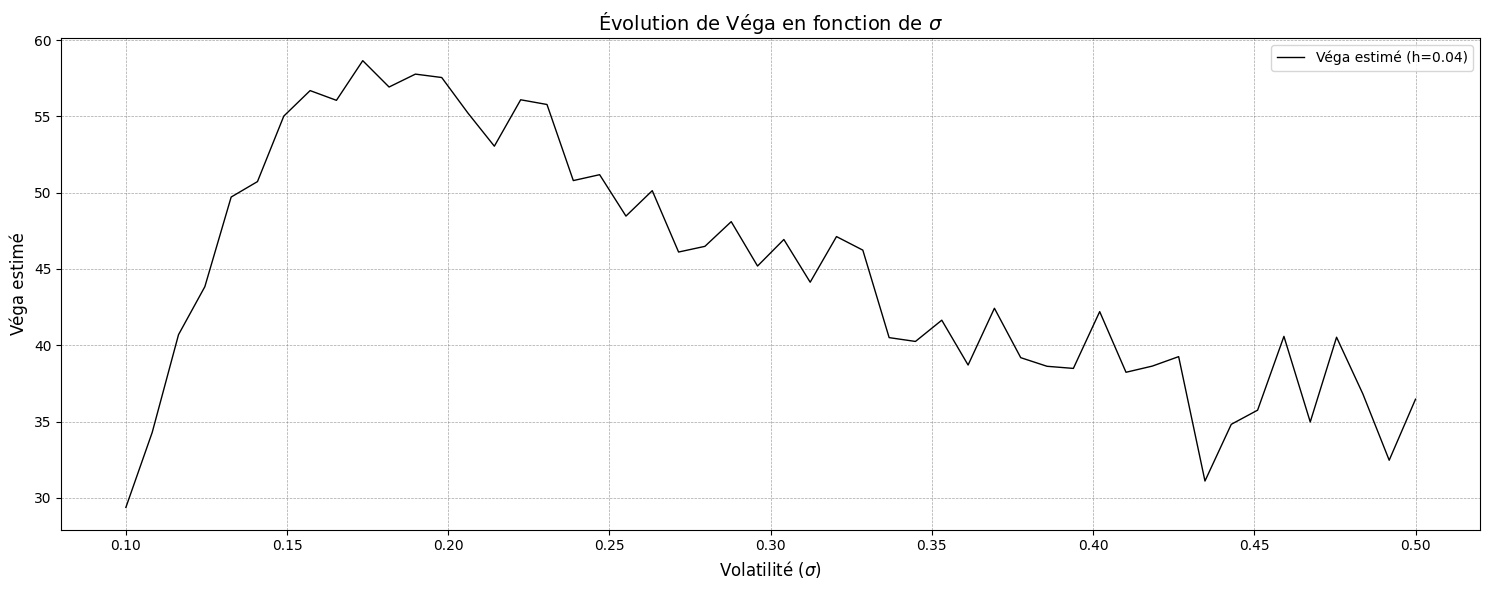

In [370]:
# ====================== Valeurs de Vega en fonction de la volatilité de l'actif ====================== #

h = 0.04  # Valeur fixe pour h
num_repeats = 200  # Nombre de répétitions pour la convergence
sigma_values = np.linspace(0.1, 0.5, 50)  # Plage des valeurs de sigma
Vega_values = []

# Calcul de Vega pour chaque sigma
for sigma in sigma_values:
    Vega = Vega_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats)
    Vega_values.append(Vega)

# ====================== Tracé du graphique 2D ====================== #
plt.figure(figsize=(15, 6))

# Tracé de la courbe avec une ligne fine
plt.plot(sigma_values, Vega_values, color='black', linestyle='-', linewidth=1, label=f'Véga estimé (h={h})')

# Ajout des labels et du titre
plt.title("Évolution de Véga en fonction de $\sigma$", fontsize=14)
plt.xlabel("Volatilité ($\sigma$)", fontsize=12)
plt.ylabel("Véga estimé", fontsize=12)

# Ajout de la légende
plt.legend(fontsize=10)

# Grille légère pour la lisibilité
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Affichage
plt.tight_layout()
plt.savefig("vega.png", dpi=300, bbox_inches="tight")
plt.show()

**Remarque et interprétation :** 

On peut dans un premier temps dire que la grecque reste positive pour toutes les valeurs de $\sigma$, ce qui confirme les résultats précedents, la volatilité est une fonction croissante de la $\text{PDD}$.

On remarque cependant que la grecque Vega n'est pas monotone en fonction de la volatilité de l'actif.

On remarque d'abord une relation croissante pour la plage de volatilité $[10\%, 20\%]$, suivie d'une décroissance sur la plage $[20\%, 50\%]$.

L'effet observé dans la première plage peut s'expliquer par le fait qu'un actif peu volatil a très peu de chances de subir une forte dépréciation. Ainsi, de manière générale, les probabilités de défaillance $\text{PDD}$ pour ce type de produits restent souvent très faibles. Par conséquent, la différence $\text{PDD}(x + h) - \text{PDD}(x - h)$ demeure relativement faible en ordre de grandeur par rapport à un actif plus volatile qui aura donc une $\text{PDD}$ plus importante.

En revanche, l'effet observé dans la seconde plage peut être attribué au fait qu'une variation de $h$ appliquée à la volatilité a un impact moins significatif sur un actif déjà fortement volatil, comparé à un actif relativement stable.


### 2.5.2 Rho

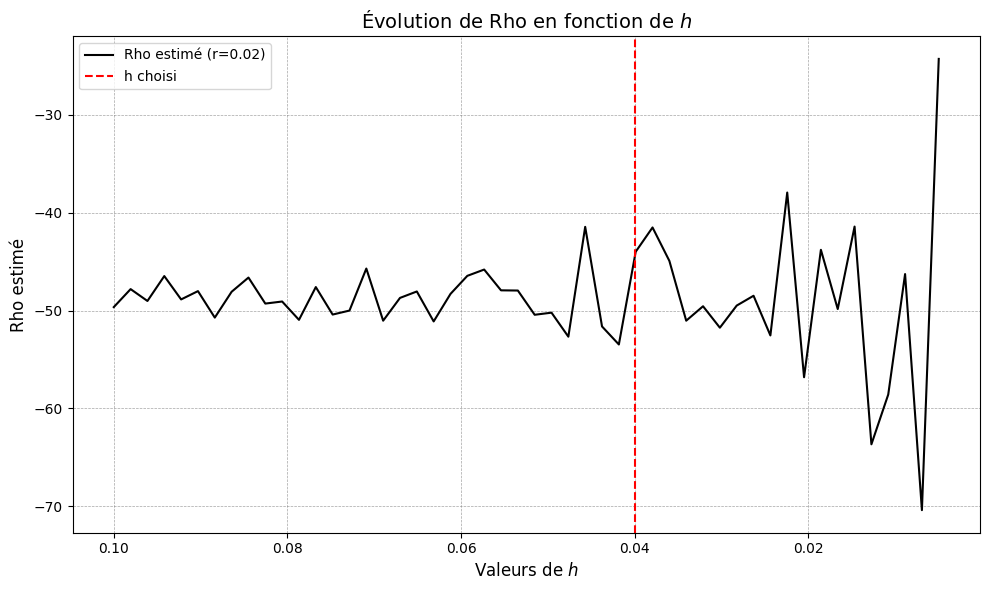

In [371]:
# ====================== Recherche d'une valeur de h ====================== #

S0 = 100
Sa = 110
N = 100
dt = 0.01
T = 1
r = 0.02
sigma = 0.3  # Volatilité
alpha = 0.75
steps = int(1 / dt)

# Fonction pour l'estimation de Rho
def Rho_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats):
    """
    Calcule la grecque Rho avec une méthode de différence finies et par itérations monte carlo.

    Arguments :
    - N : Nombre total de trajectoires simulées.
    - num_repeats : Nombre itération pour le calcul de la grecque
    - S0 : Prix initial de l'actif.
    - r : Taux sans risque.
    - sigma : Volatilité.
    - T : Nombre total de périodes simulées.
    - dt : Pas de temps pour la discrétisation.
    
    Retourne :
    - Rho : Moyenne de la grecque pour chaque scénarios num_repeats.
    """
    PDD_r_vals = []
    PDD_r_plus_vals = []
    PDD_r_minus_vals = []

    r_plus = r + h
    r_minus = r - h

    for _ in range(num_repeats):
        PDD_r = simulate_multiple_trajectories_one_period(N, S0, r, sigma, dt, steps, Sa, alpha)[1]
        PDD_r_plus = simulate_multiple_trajectories_one_period(N, S0, r_plus, sigma, dt, steps, Sa, alpha)[1]
        PDD_r_minus = simulate_multiple_trajectories_one_period(N, S0, r_minus, sigma, dt, steps, Sa, alpha)[1]

        PDD_r_vals.append(PDD_r)
        PDD_r_plus_vals.append(PDD_r_plus)
        PDD_r_minus_vals.append(PDD_r_minus)

    Rho = np.mean((np.array(PDD_r_plus_vals) - np.array(PDD_r_minus_vals)) / (2 * h))

    return Rho

# ====================== Exploration des valeurs de h ====================== #
num_repeats = 100  # Fixer le nombre d'itérations Monte Carlo
h_values = np.linspace(0.005, 0.1, 50)  # Plage des valeurs de h
rho_values = []

# Calcul de Vega pour chaque valeur de h
for h in h_values:
    rho = Rho_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats)
    rho_values.append(rho)

# ====================== Tracé du graphique 2D ====================== #
plt.figure(figsize=(10, 6))

# Tracé de la courbe en noir
plt.plot(h_values, rho_values, color='black', linestyle='-', label=f"Rho estimé (r={r})")

# Inverser l'axe des abscisses
plt.gca().invert_xaxis()

# Ajout de la ligne verticale rouge pour h = 0.04
h_choisi = 0.04
plt.axvline(x=h_choisi, color='red', linestyle='--', label="h choisi")

# Ajout des labels et du titre
plt.title("Évolution de Rho en fonction de $h$", fontsize=14)
plt.xlabel("Valeurs de $h$", fontsize=12)
plt.ylabel("Rho estimé", fontsize=12)

# Ajout de la légende
plt.legend(fontsize=10)

# Grille légère pour la lisibilité
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Affichage
plt.tight_layout()
plt.savefig("h_rho.png", dpi=300, bbox_inches="tight")
plt.show()

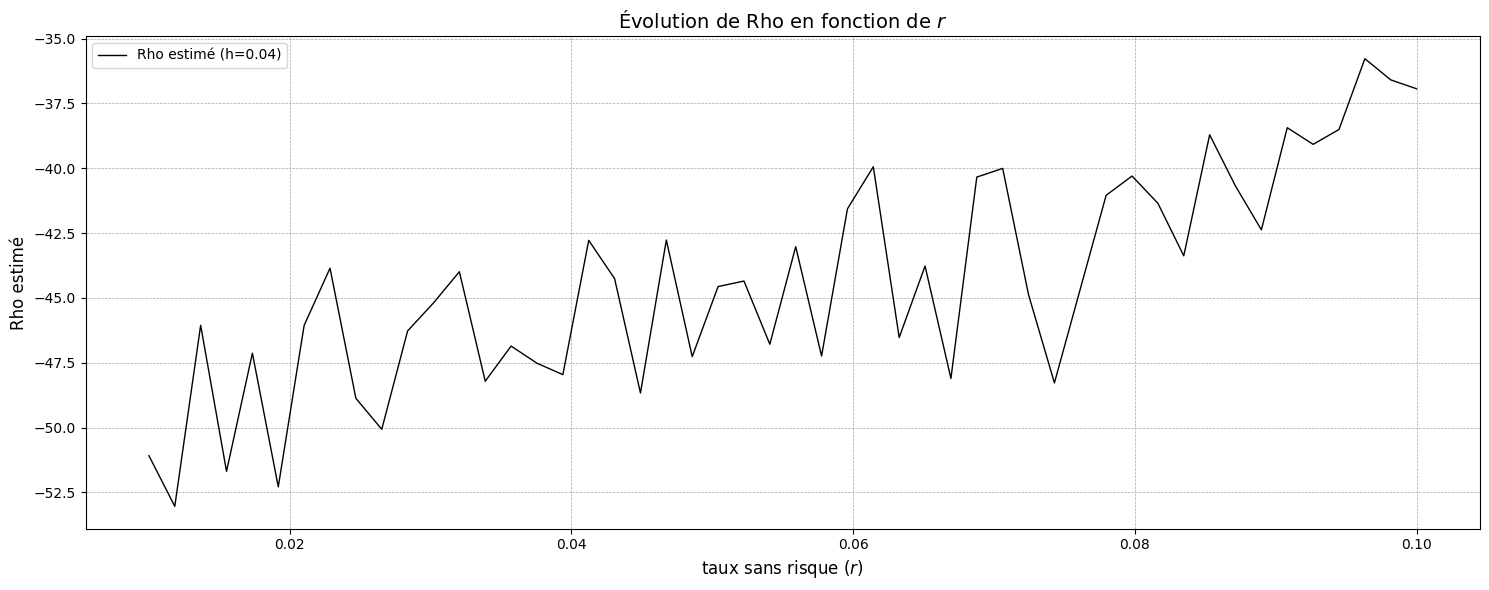

In [372]:
# ====================== Valeurs de Rho en fonction du taux sans risque du marché ====================== #

h = 0.04  # Valeur fixe pour h
num_repeats = 200  # Nombre de répétitions pour la convergence
r_values = np.linspace(0.01, 0.1, 50)  # Plage des valeurs de sigma
rho_values = []

# Calcul de rho pour chaque sigma
for r in r_values:
    rho = Rho_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats)
    rho_values.append(rho)

# ====================== Tracé du graphique 2D ====================== #
plt.figure(figsize=(15, 6))

# Tracé de la courbe avec une ligne fine
plt.plot(r_values, rho_values, color='black', linestyle='-', linewidth=1, label=f'Rho estimé (h={h})')

# Ajout des labels et du titre
plt.title("Évolution de Rho en fonction de $r$", fontsize=14)
plt.xlabel("taux sans risque ($r$)", fontsize=12)
plt.ylabel("Rho estimé", fontsize=12)

# Ajout de la légende
plt.legend(fontsize=10)

# Grille légère pour la lisibilité
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Affichage
plt.tight_layout()
plt.savefig("rho.png", dpi=300, bbox_inches="tight")
plt.show()

**Remarque et interprétation :**

On remarque ici que le signe de la grecque est clairement négatif pour l'ensemble de la plage de $r$, ce qui confirme également les résultats précedents. La $\text{PDD}$ est une fonction décroissante du taux sans risque $r$.

On peut également remarquer que la grecque est croissante selon $r$, ce qui est relativement intuitif car une petite variation de taux sera moins significative dans contexte économique où les taux sont déjà élevés.

### 2.5.3 Delta

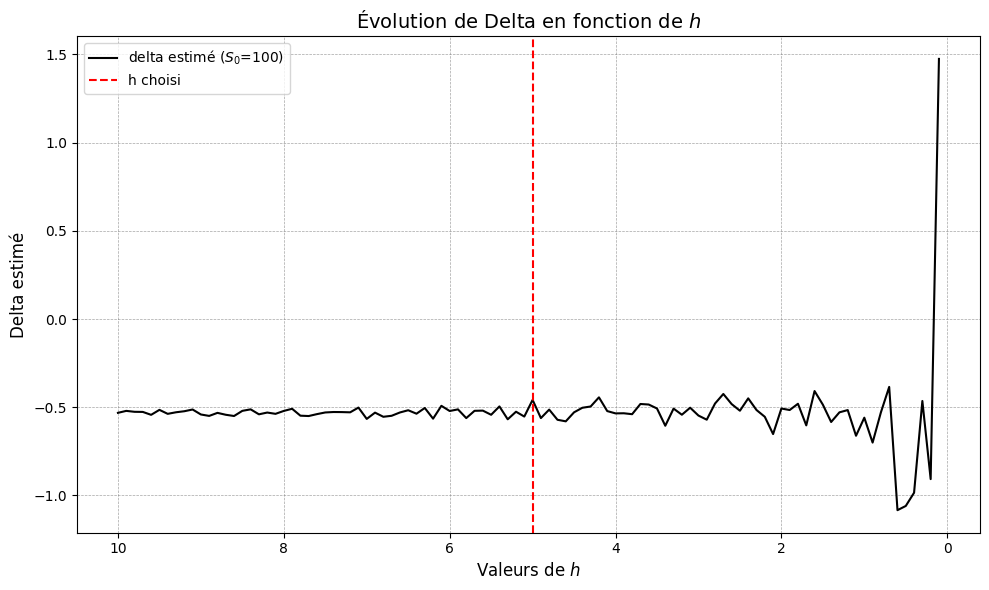

In [373]:
# ====================== Recherche d'une valeur de h ====================== #

S0 = 100
Sa = 110
N = 100
dt = 0.01
T = 1
r = 0.02
sigma = 0.3  # Volatilité
alpha = 0.75
steps = int(1 / dt)

# Fonction pour l'estimation de Delta
def Delta_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats):
    """
    Calcule la grecque Delta avec une méthode de différence finies et par itérations monte carlo.

    Arguments :
    - N : Nombre total de trajectoires simulées.
    - num_repeats : Nombre itération pour le calcul de la grecque
    - S0 : Prix initial de l'actif.
    - r : Taux sans risque.
    - sigma : Volatilité.
    - T : Nombre total de périodes simulées.
    - dt : Pas de temps pour la discrétisation.
    
    Retourne :
    - Delta : Moyenne de la grecque pour chaque scénarios num_repeats.
    """
    PDD_S0_vals = []
    PDD_S0_plus_vals = []
    PDD_S0_minus_vals = []

    S0_plus = S0 + h
    S0_minus = S0 - h

    for _ in range(num_repeats):
        PDD_S0 = simulate_multiple_trajectories_one_period(N, S0, r, sigma, dt, steps, Sa, alpha)[1]
        PDD_S0_plus = simulate_multiple_trajectories_one_period(N, S0_plus, r, sigma, dt, steps, Sa, alpha)[1]
        PDD_S0_minus = simulate_multiple_trajectories_one_period(N, S0_minus, r, sigma, dt, steps, Sa, alpha)[1]

        PDD_S0_vals.append(PDD_S0)
        PDD_S0_plus_vals.append(PDD_S0_plus)
        PDD_S0_minus_vals.append(PDD_S0_minus)

    Delta = np.mean((np.array(PDD_S0_plus_vals) - np.array(PDD_S0_minus_vals)) / (2 * h))

    return Delta

# ====================== Exploration des valeurs de h ====================== #
num_repeats = 100  # Fixer le nombre d'itérations Monte Carlo
h_values = np.linspace(0.1, 10, 100)  # Plage des valeurs de h
delta_values = []

# Calcul de Vega pour chaque valeur de h
for h in h_values:
    delta = Delta_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats)
    delta_values.append(delta)

# ====================== Tracé du graphique 2D ====================== #
plt.figure(figsize=(10, 6))

# Tracé de la courbe en noir
plt.plot(h_values, delta_values, color='black', linestyle='-', label=f"delta estimé ($S_0$={S0})")

# Inverser l'axe des abscisses
plt.gca().invert_xaxis()

# Ajout de la ligne verticale rouge pour h = 0.04
h_choisi = 5
plt.axvline(x=h_choisi, color='red', linestyle='--', label="h choisi")

# Ajout des labels et du titre
plt.title("Évolution de Delta en fonction de $h$", fontsize=14)
plt.xlabel("Valeurs de $h$", fontsize=12)
plt.ylabel("Delta estimé", fontsize=12)

# Ajout de la légende
plt.legend(fontsize=10)

# Grille légère pour la lisibilité
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Affichage
plt.tight_layout()
plt.savefig("h_delta.png", dpi=300, bbox_inches="tight")
plt.show()

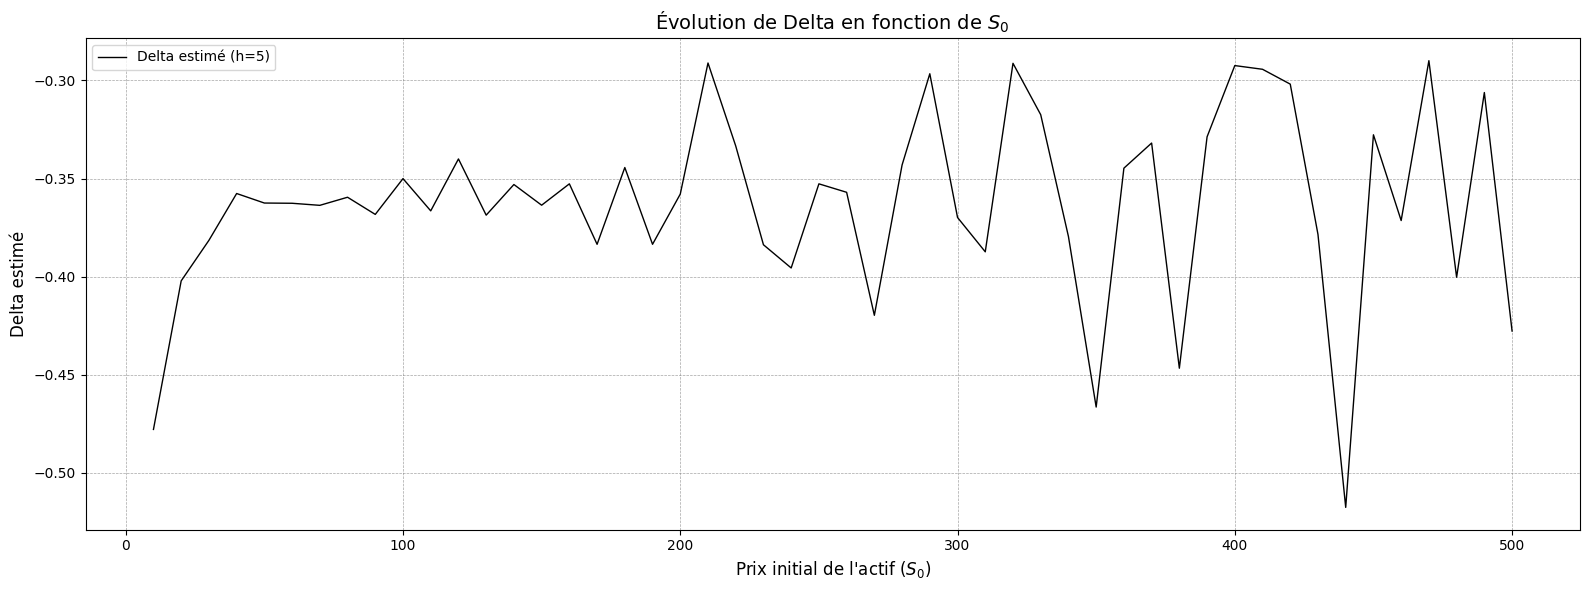

In [374]:
# ====================== Valeurs de Delta en fonction du taux sans risque du marché ====================== #

num_repeats = 200  # Nombre de répétitions pour la convergence
h = 5
S0_values = np.linspace(10, 500, 50)  # Plage des valeurs de sigma
delta_values = []

# Calcul de rho pour chaque sigma
for S0 in S0_values:
    Sa = S0
    delta = Delta_estimation(S0, Sa, N, dt, T, r, sigma, h, num_repeats)
    delta_values.append(delta)

# ====================== Tracé du graphique 2D ====================== #
plt.figure(figsize=(16, 6))

# Tracé de la courbe avec une ligne fine
plt.plot(S0_values, delta_values, color='black', linestyle='-', linewidth=1, label=f'Delta estimé (h={h})')

# Ajout des labels et du titre
plt.title("Évolution de Delta en fonction de $S_0$", fontsize=14)
plt.xlabel("Prix initial de l'actif ($S_0$)", fontsize=12)
plt.ylabel("Delta estimé", fontsize=12)

# Ajout de la légende
plt.legend(fontsize=10)

# Grille légère pour la lisibilité
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Affichage
plt.tight_layout()
plt.savefig("delta.png", dpi=300, bbox_inches="tight")
plt.show()

**Remarque et interprétations :** 
On remarque que le signe de la grecque est négatif, ce qui est très intuitif car plus $S_0$ est élevé, plus l'écart avec la barrière $0.8 * S_a$ est également élevé au début de l'exercice ce qui réduit les probabilités de dépréciation et fait baisser le montant de la $\text{PDD}$.
Aucune interprétation particulière sur la monotonie. (manque de précision).

<a id='3'></a>

# 3. Plusieurs actifs

### Construction d'un portefeuille aléatoire :



**Composition portefeuille :**

$$
\{S_1, S_2, \dots, S_5, 2S_6, 2S_7, \dots, 2S_{10}\}.
$$

---



**Matrice de corrélation :**





La matrice de corrélation est définie comme suit :

$
\rho_{ij} =
\begin{cases}
1 & \text{si } i = j, \\
u_{ij} & \text{si } i \neq j,
\end{cases}
$
$\space$ $\space$ $\space$ où  $u_{ij} \sim \mathcal{U}[0, 1]$

---

**Données des actifs :**
- $ S_a \sim \mathcal{U}[100, 120]$
- $ S_0 \sim \mathcal{U}[90, 110]$
- $ \sigma^i \sim \mathcal{U}[0.1, 0.5]$

---


On rappelle l'ensemble des matrices symétriques définies strictement positives $ S_n^{++}(\mathbb{R}) $, sous ensemble de $ \mathcal{M}_n(\mathbb{R}) $, défini comme suit :

$$
S_n^{++}(\mathbb{R}) = \{ A \in \mathcal{M}_n(\mathbb{R}) \ | \ A = A^T \ \text{et} \ \forall x \in \mathbb{R}^n \setminus \{0\}, \ x^T A x > 0 \}.
$$



### Définition de la décomposition de Cholesky

Pour toute matrice $ A \in S_n^{++}(\mathbb{R}) $, il existe une unique matrice triangulaire inférieure $ L $ telle que :

$$
A = LL^T,
$$


**Application vecteurs Gaussiens :**  (C.f cours M.THOMAS)

Soit $X$ un vecteur gaussien, alors, par définition, $X$ s'écrit :

$$
X = \mu + AZ,
$$

où :
- $ \mu $ est l'espérance de $ X $,
- $ A $ est une matrice $ n \times n $ telle que $ \Sigma = AA^T $, avec $ \Sigma $ la matrice de covariance de $ X $,
- $ Z \in \mathbb{R}^n $ est un vecteur dont les composantes sont des variables normales centrées réduites indépendantes ($ Z_i \sim \mathcal{N}(0, 1) $).


La décomposition de Cholesky est utilisée pour construire une matrice $ A $ telle que $ \Sigma = AA^T $. 

- Si $ \Sigma \in S_n^+(\mathbb{R}) $ (matrice symétrique définie positive, strictement si on veut également l'unicité), alors il existe une matrice triangulaire inférieure $ L $ (issue de la décomposition de Cholesky) telle que :
  $$
  \Sigma = LL^T.
  $$
- En choisissant $ A = L $, on peut écrire $ X $ comme :
  $$
  X = \mu + LZ.
  $$

Cette méthode permet de générer des vecteurs gaussiens multivariés en simulant $ Z $, puis en appliquant une transformation linéaire via $ L $.

---

In [955]:
# ================ On teste si les conditions de construction de la matrice de covariance sont cohérentes avec la condition définie positive de Cholesky ============= #

def est_definie_positive_valeurs_propres(A):
    """
    Vérifie si une matrice est définie positive via ses valeurs propres.
    
    Arguments:
        A (np.ndarray): Une matrice carrée.
        
    Retourne:
        bool: True si toutes les valeurs propres sont > 0, False sinon.
    """
    valeurs_propres = np.linalg.eigvals(A)
    return np.all(valeurs_propres > 0)

# Simulation de n_simulations matrices de corrélation et comptage des définies positives
def compter_matrices_def_pos(d, n_simulations):
    compteur = 0  # Compteur pour les matrices définies positives
    for _ in range(n_simulations):
        # Génération de la matrice de corrélation
        uij = np.random.uniform(0, 1, size=(d, d))  # Lois uniformes pour i ≠ j
        rho = (uij + uij.T) / 2  # Assurer la symétrie
        np.fill_diagonal(rho, 1)  # Mettre des 1 sur la diagonale

        # Génération d'une matrice de covariance
        volatilities = np.random.uniform(0.1, 0.5, size=d)  
        Sigma = np.outer(volatilities, volatilities) * rho

        # Tester si rho est définie positive
        if est_definie_positive_valeurs_propres(Sigma):
            compteur += 1  # Incrémenter le compteur si définie positive
    
    return compteur

# Paramètres
d = 10  # Dimension des matrices
n_simulations = 1000000  # Nombre de matrices à générer

# Lancer la simulation
nombre_def_pos = compter_matrices_def_pos(d, n_simulations)

# Résultats
pourcentage_def_pos = (nombre_def_pos / n_simulations) * 100  # Calcul du pourcentage
print(f"Nombre de matrices de covariances définies positives sur {n_simulations} : {nombre_def_pos}")
print(f"Pourcentage de matrices définies positives : {pourcentage_def_pos:.2f}%")

Nombre de matrices de covariances définies positives sur 1000000 : 95
Pourcentage de matrices définies positives : 0.01%


In [1053]:
# ====================== Fonction qui tire une matrice de covariance définie positive ====================== #

def cov_matrix_simul(d):
    """
    Simule une matrice de covariance et corrélation définie positive.
    
    Arguments:
        d (int): Dimension de la matrice de covariance.
        
    Retourne:
        np.ndarray: Une matrice de covariance définie positive.
        np.ndarray: Le vecteur des volatilités.
        np.ndarray: La matrice de corrélation associée.
    """
    while True:
        # Génération d'une matrice de corrélation
        uij = np.random.uniform(0, 1, size=(d, d))  # Lois uniformes pour i ≠ j
        rho = (uij + uij.T) / 2  # Symétrisation
        np.fill_diagonal(rho, 1)  # Mettre des 1 sur la diagonale

        # Génération d'une matrice de covariance
        volatilites = np.random.uniform(0.1, 0.5, size=d)  
        Sigma = np.outer(volatilites, volatilites) * rho

        # Test si ma matrice est définie positive
        if est_definie_positive_valeurs_propres(Sigma):
            return Sigma, volatilites, rho  
        

# On tire nos matrice / vecteurs
_ = cov_matrix_simul(10)
Sigma = _[0]
volatilites = _[1]
rho = _[2]

**Remarque :** Il est possible que le critère de définie positive imposé modifie complètement la distribution des coefficients de $\rho$ (qu'ils ne soient plus uniformes). Cependant, nous considérons qu'il s'agit d'une erreur dans la construction de l'énoncé, et nous supposons qu'il n'est pas possible de procéder autrement.

# Explication et vérification Cholesky


### Méthode : Je calcule la matrice de cov empirique et je vérifie que c'est mon Sigma

In [1054]:
# ====================== Test Cholesky ====================== #

# Paramètres
d = 10  # Nombre d'actifs
n_simulations = 10000  # Nombre de simulations
r = 0.02  # Taux sans risque
dt = 1/252  # Taille d'un pas de temps (exemple : 1 jour)

# Volatilités des actifs (racine de la diagonale de Sigma)
volatilities = np.sqrt(np.diag(Sigma))

# Décomposition de Cholesky (Sigma ajustée pour le pas de temps)
L = cholesky(Sigma, lower=True)  # Ajustée pour le pas de temps
# L = cholesky(Sigma*dt, lower=True)  # Seconde possibilité si on doit simuler des vecteurs centrées réduits 


# Calcul du drift (vecteur)
drift = (r - 0.5 * volatilities**2) * dt

# Simulation des rendements indépendants (normaux standard)
log_rendements_indep = np.random.normal(loc=0, scale=np.sqrt(dt), size=(n_simulations, d))     # On aurait pris scale = 1 si : cholesky(Sigma*dt, lower=True)

# Application de Cholesky pour corrélation et ajout du drift
log_rendements_corr = (log_rendements_indep @ L.T) + drift

# Matrices empiriques
cov_empirique = np.cov(log_rendements_corr, rowvar=False)
corr_empirique = np.corrcoef(log_rendements_corr, rowvar=False)

# Affichage des résultats
print("\nMatrice de covariance théorique (Sigma * dt) :\n", Sigma * dt)
print("\nMatrice de covariance empirique :\n", cov_empirique)

# Évaluation de l'erreur
erreur_cov = np.linalg.norm(cov_empirique - Sigma * dt)
print("\nErreur entre la matrice de covariance théorique et empirique :", erreur_cov)


Matrice de covariance théorique (Sigma * dt) :
 [[3.49442637e-04 2.35790914e-04 1.47315288e-04 5.63325303e-05
  2.07464958e-04 1.11511568e-04 4.51430100e-05 2.06888759e-04
  1.43757138e-04 5.57590751e-05]
 [2.35790914e-04 5.32826301e-04 2.55293656e-04 7.65016896e-05
  2.83249479e-04 1.30370967e-04 7.52792617e-05 4.03289944e-04
  4.03237167e-04 1.26146176e-04]
 [1.47315288e-04 2.55293656e-04 8.99012844e-04 6.40537083e-05
  4.13503118e-04 1.87231863e-04 1.88468356e-04 3.70278349e-04
  3.50662120e-04 2.42047830e-04]
 [5.63325303e-05 7.65016896e-05 6.40537083e-05 4.04375307e-05
  5.07761429e-05 5.09268885e-05 1.69063662e-05 5.44799975e-05
  6.98030449e-05 4.54780691e-05]
 [2.07464958e-04 2.83249479e-04 4.13503118e-04 5.07761429e-05
  4.17109670e-04 1.25435686e-04 6.29735307e-05 3.22089410e-04
  1.87881870e-04 1.21162242e-04]
 [1.11511568e-04 1.30370967e-04 1.87231863e-04 5.09268885e-05
  1.25435686e-04 1.11010545e-04 4.12877945e-05 1.23990275e-04
  1.30563833e-04 8.52506811e-05]
 [4.51430

**Remarque :** C'est la même matrice de covariance (théorique vs empirique), la démarche est donc correcte

<a id="3_1"></a>
## 3.1 Construction d’un model point sur une période

On rappelle :

$$
S_t^0 = \sum_{i=1}^{10} \lambda_i S_t^i = \lambda^\top S_t
$$

où $ S_t = (S_t^1, \dots, S_t^{10}) $ est le vecteur des actifs et $ \lambda = (\lambda_1, \dots, \lambda_{10}) $ est le vecteur du nombre d'actif.

--- 

On obtient donc immédiatement :

- #### $S_0^0 = \sum_{i=1}^{10} \lambda_i S_0^i = \lambda^\top S_0$

- #### $S_a^0 = \sum_{i=1}^{10} \lambda_i S_a^i = \lambda^\top S_a$

--- 

Recherche de volatilité :

On utilise une approximation par rendements arithmétiques :

$$
V(r_t^0) = V(\frac{S_t^0 - S_{t-1}^0}{S_{t-1}^0}) = V(\frac{\sum_{i=1}^{10} \lambda_i (S_t^i - S_{t-1}^i)}{S_{t-1}^0}) = V(\sum_{i=1}^{10} \frac{\lambda_i S_{t-1}^i}{S_{t-1}^0} \space \frac{(S_t^i - S_{t-1}^i)}{S_{t-1}^i}) = V(\sum_{i=1}^{10} \omega_t^{i} \space r_t^i) = V(\omega_t^\top r_t) = \omega_t^\top Cov(r_t) \omega_t
$$


$$
\implies \sigma_t^0 = \sqrt{V(r_t^0)} = \sqrt{\omega_t^\top Cov(r_t) \omega_t}
$$


In [1055]:
# ====================== Calcul numérique des paramètres de S° ====================== #

# Paramètres
d = 10  # Nombre d'actifs

# Prix initial et prix d'acquisition du model point
S0_actifs = np.random.uniform(90, 110, size=d)  # Valeurs des actifs au temps t = 0
Sa_actifs = np.random.uniform(100, 120, size=d)  # Valeurs d'acquisition des actifs

# Vecteur des poids / nb d'actifs
lambda_ = np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
lambda_weights = lambda_ / np.sum(lambda_)   # Bonne approximation, on est obligé car de toute façon, dans notre modèle la volatilité est supposée constante
# lambda_weights = lambda_ * S0_actifs / np.dot(lambda_, S0_actifs) : pour plus de précision

# Calcul des prix agrégés (S0 et Sa)
S0 = np.dot(lambda_, S0_actifs)
Sa = np.dot(lambda_, Sa_actifs)

# Calcul de la volatilité du model point
Variance = np.dot(lambda_weights, np.dot(Sigma, lambda_weights))
vol = np.sqrt(Variance)

# Récapitulation des caractéristiques
data = {
    "Actifs": [f"Actif {i+1}" for i in range(d)],
    "S0 (t=0)": S0_actifs,
    "Sa (acquisition)": Sa_actifs,
    "Volatilité": volatilites,
    "Poids (λ)": lambda_weights,
}

table = pd.DataFrame(data)

# Affichage
print("===== Tableau récapitulatif des actifs =====")
print(table)

print("\n===== Paramètres agrégés du model point =====")
print(f"S0 agrégé : {S0:.2f}")
print(f"Sa agrégé : {Sa:.2f}")
print(f"Volatilité agrégée : {vol:.4f}")

===== Tableau récapitulatif des actifs =====
     Actifs    S0 (t=0)  Sa (acquisition)  Volatilité  Poids (λ)
0   Actif 1   97.426430        110.989520    0.296748   0.066667
1   Actif 2   95.579250        108.487354    0.366432   0.066667
2   Actif 3   97.416850        117.478820    0.475974   0.066667
3   Actif 4  102.764535        100.916172    0.100947   0.066667
4   Actif 5   93.453995        117.605229    0.324209   0.066667
5   Actif 6   99.170957        110.528071    0.167256   0.133333
6   Actif 7   92.168936        107.590385    0.116512   0.133333
7   Actif 8   95.585498        115.698119    0.453455   0.133333
8   Actif 9   96.900626        117.608993    0.350057   0.133333
9  Actif 10   92.073427        102.640156    0.196479   0.133333

===== Paramètres agrégés du model point =====
S0 agrégé : 1438.44
Sa agrégé : 1663.61
Volatilité agrégée : 0.2117


In [1057]:
# ====================== Calcul PDD du model point sur une période ====================== #

# Paramètres
T = 10  # Nombre de périodes (en années)
N = 1000  # Nombre d'itérations Monte Carlo
r = 0.02  # Taux sans risque
sigma = vol # Volatilité agrégée du model point
dt = 0.01  # Pas de temps

# Calcul des métriques
PDD, deprecation_prob = simulate_multiple_trajectories_multiple_periods_naive(N, S0, r, sigma, T, dt)

# Affichage amélioré des résultats
print("=" * 50)
print("         Résultats de la simulation PDD raffinée        ")
print("=" * 50)
print(f"Nombre de simulations (N)                : {N}")
print(f"Durée de la période (T)                  : {T} an(s)")
print(f"Pas de temps (dt)                        : {dt:.6f} an(s)")
print(f"Nombre de pas dans la discrétisation     : {steps}")

print("-" * 50)
print(f"PDD1 (totale)                            : {PDD[0]:.4f}")
print(f"Probabilité de dépréciation              : {deprecation_prob[0]:.2%}")
print("=" * 50)

Simulation des trajectoires naïves: 100%|██████████| 1000/1000 [00:01<00:00, 704.81it/s]

         Résultats de la simulation PDD raffinée        
Nombre de simulations (N)                : 1000
Durée de la période (T)                  : 10 an(s)
Pas de temps (dt)                        : 0.010000 an(s)
Nombre de pas dans la discrétisation     : 100
--------------------------------------------------
PDD1 (totale)                            : 156.0756
Probabilité de dépréciation              : 27.20%


<a id="3_2"></a>
## 3.2 Méthodes ligne à ligne

In [1060]:
# ====================== Simulation 1 trajectoire plusieurs actifs ====================== #

def simulate_trajectory_multiple_periods_multiple_assets_naive(S0, r, Sigma, T, dt, n_assets):
    """
    Simule les trajectoires pour plusieurs actifs sur T périodes avec une méthode naïve et applique des pénalités.

    Arguments :
    - S0 : Vecteur prix initiaux (taille n_assets).
    - r : Taux sans risque.
    - Sigma : Matrice de covariance (taille n_assets x n_assets).
    - T : Nombre total de périodes.
    - dt : Pas de temps pour la discrétisation.
    - n_assets : Nombre d'actifs.

    Retourne :
    - all_lambda : Matrice des pénalités (\(\lambda\)) calculées pour chaque période et chaque actif.
    - total_lambda : Somme totale des pénalités sur toutes les périodes et tous les actifs.
    - trajectory : Les trajectoires simulées.
    """
    alpha = 0.75  # Facteur constant
    steps_per_period = int(1 / dt)  # Nombre de pas par période
    L = np.linalg.cholesky(Sigma)  # Décomposition de Cholesky

    # Initialisation
    trajectory = np.zeros((steps_per_period + 1, T, n_assets))
    all_lambda = np.zeros((T, n_assets))
    vec_active = np.zeros((steps_per_period + 1, T, n_assets), dtype=int)  # Suivi des dépassements
    bool_active = np.ones((T, n_assets), dtype=bool)

    for period in range(T):
        # Calcul de la barrière dynamique pour chaque actif
        Omega = Sa_actifs - np.sum(all_lambda, axis=0)

        # Génération des incréments Brownien
        Z = np.random.normal(0, 1, size=(steps_per_period, n_assets))
        Z = Z @ L.T  # Appliquer les corrélations

        # Initialisation pour chaque période
        if period == 0:
            trajectory[0, period, :] = S0
        else:
            trajectory[0, period, :] = trajectory[-1, period - 1, :]

        # Simulation de trajectoires
        for t in range(steps_per_period):
            trajectory[t + 1, period, :] = trajectory[t, period, :] * np.exp(
                (r - 0.5 * np.diag(Sigma)) * dt + np.sqrt(dt) * Z[t, :]
            )
            if t >= steps_per_period // 2:
                vec_active[t + 1, period, :] = vec_active[t, period, :] + (trajectory[t + 1, period, :] > Sa_actifs)

        # Vérification des dépassements
        bool_active[period, :] = (vec_active[-1, period, :] == 0)

        # Calcul des pénalités
        S_T = trajectory[-1, period, :]
        for asset in range(n_assets):
            if bool_active[period, asset] and S_T[asset] <= alpha * Sa_actifs[asset]:
                all_lambda[period, asset] = max(Omega[asset] - S_T[asset], 0)

    # Calcul des pénalités totales par période
    total_lambda = np.sum(all_lambda * lambda_, axis=1)

    return all_lambda, total_lambda, trajectory




# ====================== Simulation N trajectoire naïve sur T périodes + PDD ====================== #

def simulate_multiple_trajectories_multiple_periods_multiple_assets_naive(N, S0, r, Sigma, T, dt, n_assets):
    """
    Simule plusieurs trajectoires de plusieurs actifs sur T périodes et calcule la PDD.

    Paramètres :
    - N : Nombre total de trajectoires simulées.
    - S0 : Vecteur prix initiaux.
    - r : Taux sans risque.
    - Sigma : Matrice covariance.
    - T : Nombre total de périodes simulées.
    - dt : Pas de temps pour la discrétisation.
    - n_assets : Nombre d'actifs.

    Retourne :
    - PDD : Vecteur des PDD pour chaques périodes.
    """

    # Tableau pour accumuler les pénalités \(\lambda\) sur toutes les périodes et trajectoires
    all_lambda = np.array([])

    for _ in tqdm(range(N), desc="Simulation des trajectoires naïves"):  # Boucle sur le nombre de simulations
        # Simule une trajectoire unique sur plusieurs périodes
        _, total_lambda, _ = simulate_trajectory_multiple_periods_multiple_assets_naive(
            S0_actifs, r, Sigma, T, dt, n_assets
        )

        # Ajoute les pénalités \(\lambda\) calculées pour cette trajectoire
        all_lambda = np.concatenate((all_lambda, total_lambda))


    # Reshape de all_lambda pour correspondre au format (N simulations, T périodes)
    all_lambda = all_lambda.reshape(N, T)

    # Moyenne des pénalités \(\lambda\) par période
    means_all_lambda_columns = np.mean(all_lambda, axis=0)

    # PDD cumulée (somme des moyennes par période)
    PDD = np.cumsum(means_all_lambda_columns)

    return PDD

# Paramètres de simulation
n_assets = 10                 # Nombre d'actifs
r = 0.02                      # Taux sans risque (5% annuel)
T = 10                         # Nombre de périodes (5 années)
dt = 0.01                  # Pas de temps (1 jour de marché, 252 jours par an)
N = 1000

# Appel de la fonction
PDD = simulate_multiple_trajectories_multiple_periods_multiple_assets_naive(N, S0_actifs, r, Sigma, T, dt, n_assets)
# Affichage des résultats
print("Pénalités (\u03BB) par période :")
print(PDD)

Simulation des trajectoires naïves: 100%|██████████| 1000/1000 [00:05<00:00, 179.00it/s]

Pénalités (λ) par période :
[188.5600356  309.44728287 391.0007592  458.06330429 511.0910397
 557.19353374 596.1366963  630.52493692 662.86638197 689.16869987]


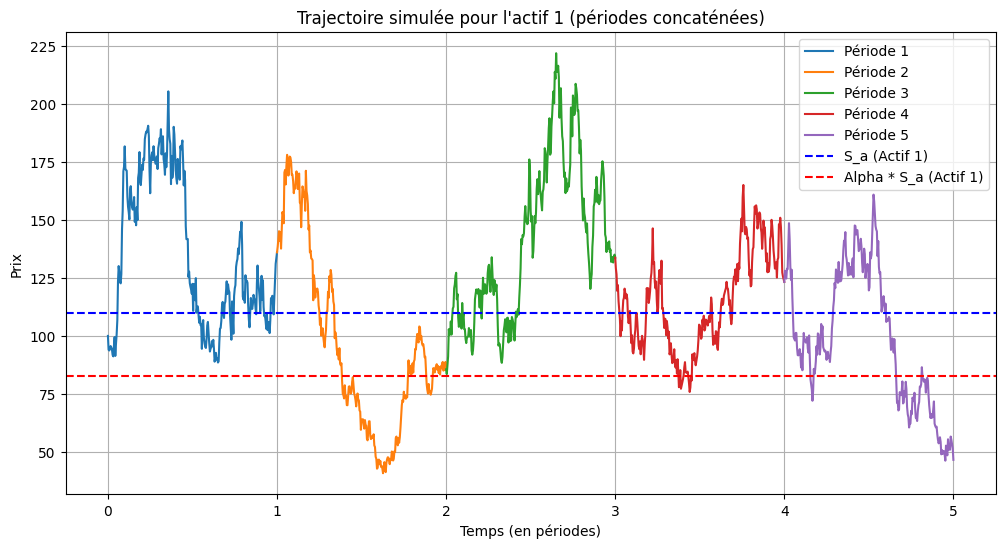

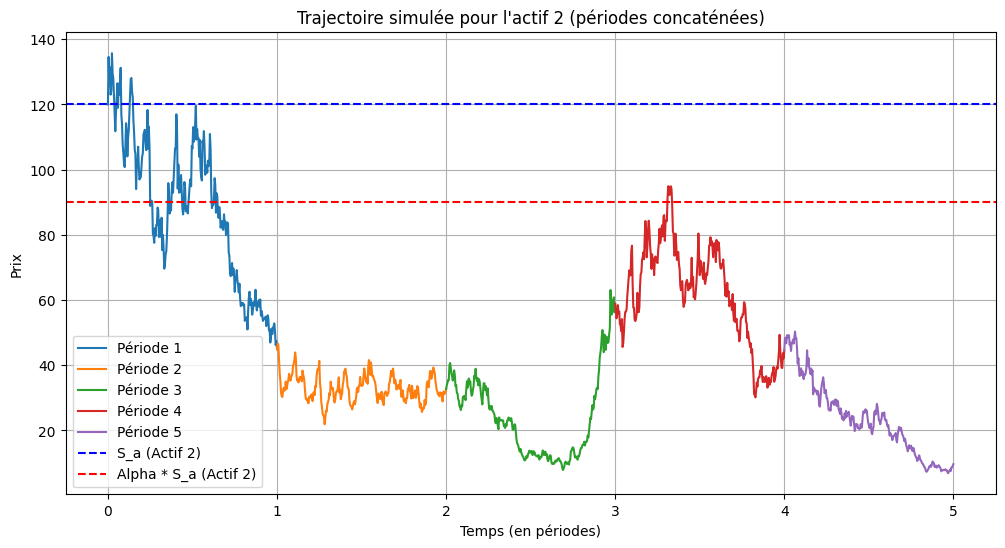

Matrice all_lambda :
 [[ 0.         75.06426171]
 [ 0.         12.23125101]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.         23.03452741]]
Somme totale des pénalités par période : [75.06426171 12.23125101  0.          0.         23.03452741]


In [1043]:
# ====================== Fonction test ====================== #

def simulate_trajectory_multiple_periods_multiple_assets_naive_test(S0, r, Sigma, T, dt, n_assets, Sa_actifs, lambda_):
    """
    Simule les trajectoires pour plusieurs actifs sur T périodes avec une méthode naïve et applique des pénalités.

    Arguments :
    - S0 : Vecteur prix initiaux (taille n_assets).
    - r : Taux sans risque.
    - Sigma : Matrice de covariance (taille n_assets x n_assets).
    - T : Nombre total de périodes.
    - dt : Pas de temps pour la discrétisation.
    - n_assets : Nombre d'actifs.
    - Sa_actifs : Niveau critique \( S_a \) pour chaque actif (taille n_assets).
    - lambda_ : Poids associés aux actifs dans le calcul de la pénalité totale.

    Retourne :
    - all_lambda : Matrice des pénalités (\(\lambda\)) calculées pour chaque période et chaque actif.
    - total_lambda : Somme totale des pénalités sur toutes les périodes et tous les actifs.
    - trajectory : Les trajectoires simulées.
    """
    alpha = 0.75  # Facteur constant
    steps_per_period = int(1 / dt)  # Nombre de pas par période
    L = np.linalg.cholesky(Sigma)  # Décomposition de Cholesky

    # Initialisation
    trajectory = np.zeros((steps_per_period + 1, T, n_assets))
    all_lambda = np.zeros((T, n_assets))
    vec_active = np.zeros((steps_per_period + 1, T, n_assets), dtype=int)  # Suivi des dépassements
    bool_active = np.ones((T, n_assets), dtype=bool)

    for period in range(T):
        # Calcul de la barrière dynamique pour chaque actif
        Omega = Sa_actifs - np.sum(all_lambda, axis=0)

        # Génération des incréments Brownien
        Z = np.random.normal(0, 1, size=(steps_per_period, n_assets))
        Z = Z @ L.T  # Appliquer les corrélations

        # Initialisation pour chaque période
        if period == 0:
            trajectory[0, period, :] = S0
        else:
            trajectory[0, period, :] = trajectory[-1, period - 1, :]

        # Simulation de trajectoires
        for t in range(steps_per_period):
            trajectory[t + 1, period, :] = trajectory[t, period, :] * np.exp(
                (r - 0.5 * np.diag(Sigma)) * dt + np.sqrt(dt) * Z[t, :]
            )
            if t >= steps_per_period // 2:
                vec_active[t + 1, period, :] = vec_active[t, period, :] + (trajectory[t + 1, period, :] > Sa_actifs)

        # Vérification des dépassements
        bool_active[period, :] = (vec_active[-1, period, :] == 0)

        # Calcul des pénalités
        S_T = trajectory[-1, period, :]
        for asset in range(n_assets):
            if bool_active[period, asset] and S_T[asset] <= alpha * Sa_actifs[asset]:
                all_lambda[period, asset] = max(Omega[asset] - S_T[asset], 0)

    # Calcul des pénalités totales par période
    total_lambda = np.sum(all_lambda * lambda_, axis=1)
    return all_lambda, total_lambda, trajectory

# ==== TEST ET VISUALISATION ====

# Paramètres de simulation
s0 = np.array([100, 120])  # Prix initiaux
r = 0.02  # Taux sans risque
tigma = np.array([[0.6, 0.01], [0.01, 0.8]])  # Matrice de covariance
T = 5  # Nombre de périodes
dt = 1 / 252  # Pas de temps (1 jour de bourse)
n_asset = 2  # Nombre d'actifs
sa_actifs = np.array([110, 120])  # Seuil critique pour chaque actif
lambd_ = np.array([1, 1])  # Poids des actifs

# Simulation
all_lambda, total_lambda, trajectory = simulate_trajectory_multiple_periods_multiple_assets_naive_test(
    s0, r, tigma, T, dt, n_asset, sa_actifs, lambd_
)

# Création de l'abscisse (temps global, périodes concaténées)
steps_per_period = int(1 / dt)
time_global = np.linspace(0, T, steps_per_period * T + 1)

# Visualisation des trajectoires concaténées
for asset in range(n_asset):
    plt.figure(figsize=(12, 6))
    for period in range(T):
        start_idx = period * steps_per_period
        end_idx = start_idx + steps_per_period + 1
        plt.plot(time_global[start_idx:end_idx], trajectory[:, period, asset], label=f"Période {period + 1}")

    # Tracer les barrières
    plt.axhline(y=sa_actifs[asset], color='blue', linestyle='--', label=f"S_a (Actif {asset + 1})")
    plt.axhline(y=0.75 * sa_actifs[asset], color='red', linestyle='--', label=f"Alpha * S_a (Actif {asset + 1})")

    plt.title(f"Trajectoire simulée pour l'actif {asset + 1} (périodes concaténées)")
    plt.xlabel("Temps (en périodes)")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid()
    plt.show()

# Affichage des pénalités
print("Matrice all_lambda :\n", all_lambda)
print("Somme totale des pénalités par période :", total_lambda)

**Remarque :** Si on s'amuse à simuler plusieurs fois, la fonction renvoie bien le résultat attendu.

<a id="3_3"></a>
## 3.3 Comparaison des méthodes

### 3.3.1 Comparaison des estimations :

Simulation des trajectoires naïves: 100%|██████████| 1000/1000 [00:01<00:00, 743.15it/s]


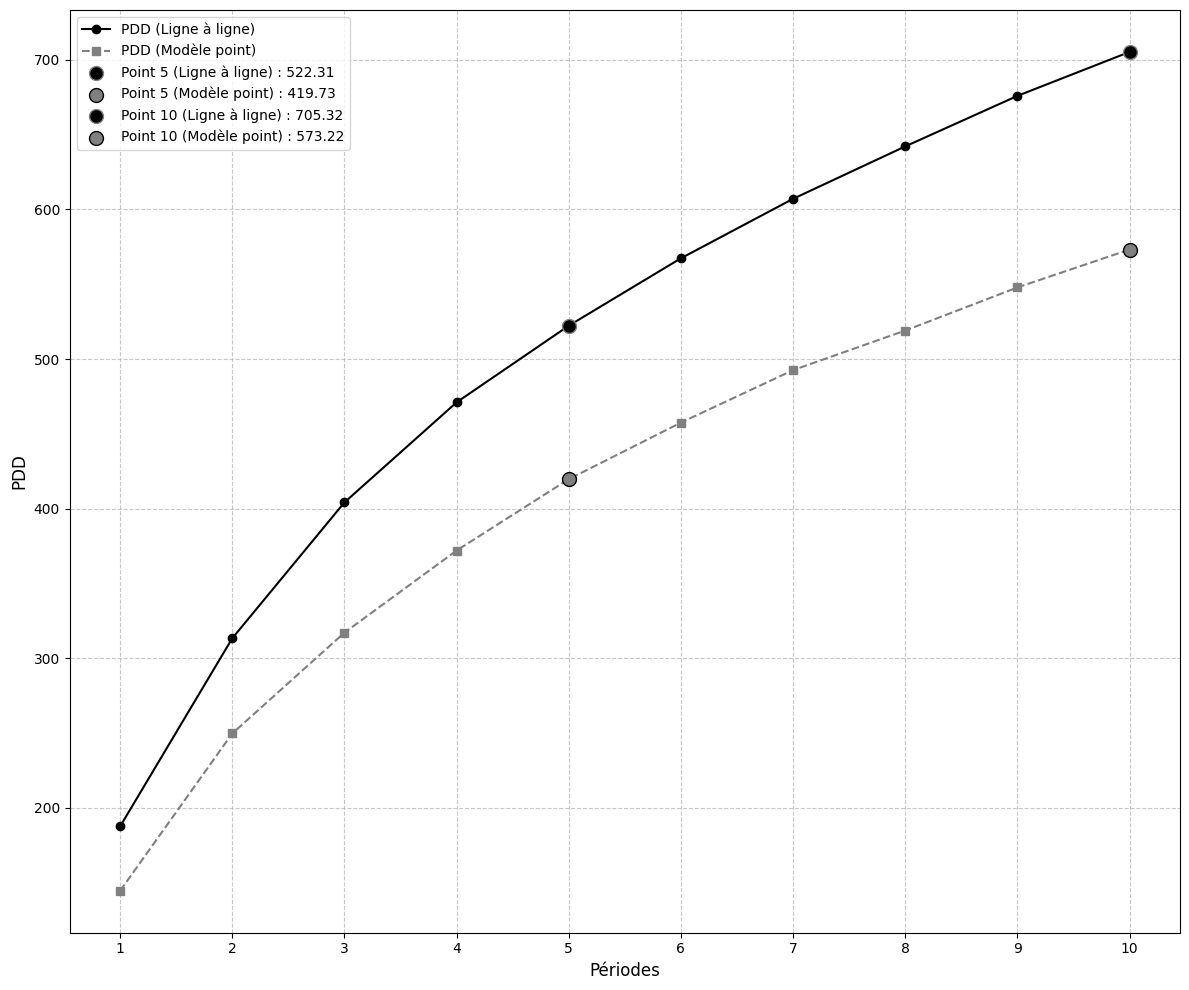

In [1074]:
# ====================== Données de simulation ====================== #
n_assets = 10                # Nombre d'actifs
r = 0.02                     # Taux sans risque (2% annuel)
T = 10                       # Nombre de périodes (10 années)
dt = 0.01                    # Pas de temps (1 jour de marché)
N = 1000                     # Nombre d'itérations Monte Carlo
sigma = vol                  # Volatilité agrégée du model point

# ====================== Appels des fonctions de simulation ====================== #

# Fonction ligne à ligne
PDD_assets = simulate_multiple_trajectories_multiple_periods_multiple_assets_naive(
    N, S0_actifs, r, Sigma, T, dt, n_assets
)

# Fonction modèle point
PDD_model_point, deprecation_prob = simulate_multiple_trajectories_multiple_periods_naive(
    N, S0, r, sigma, T, dt
)

# ====================== Tracé des résultats ====================== #

# Création d'un vecteur pour l'axe des périodes (1 à T)
time_periods = np.arange(1, T + 1)

# Valeurs arrondies pour les points 5 et 10
PDD_assets_5 = round(PDD_assets[4], 2)  # PDD à la période 5 (index 4)
PDD_assets_10 = round(PDD_assets[9], 2)  # PDD à la période 10 (index 9)

PDD_model_point_5 = round(PDD_model_point[4], 2)  # PDD à la période 5 (index 4)
PDD_model_point_10 = round(PDD_model_point[9], 2)  # PDD à la période 10 (index 9)

# Création du graphique
plt.figure(figsize=(12, 10))

# Tracé des PDD pour la méthode ligne à ligne
plt.plot(time_periods, PDD_assets, label="PDD (Ligne à ligne)", marker='o', linestyle='-', color='black')

# Tracé des PDD pour la méthode modèle point
plt.plot(time_periods, PDD_model_point, label="PDD (Modèle point)", marker='s', linestyle='--', color='gray')

# Mise en évidence des points 5 et 10 avec leurs valeurs dans la légende
plt.scatter([5], [PDD_assets[4]], color='black', label=f"Point 5 (Ligne à ligne) : {PDD_assets_5}", s=100, edgecolors='gray', zorder=5)
plt.scatter([5], [PDD_model_point[4]], color='gray', label=f"Point 5 (Modèle point) : {PDD_model_point_5}", s=100, edgecolors='black', zorder=5)

plt.scatter([10], [PDD_assets[9]], color='black', label=f"Point 10 (Ligne à ligne) : {PDD_assets_10}", s=100, edgecolors='gray', zorder=5)
plt.scatter([10], [PDD_model_point[9]], color='gray', label=f"Point 10 (Modèle point) : {PDD_model_point_10}", s=100, edgecolors='black', zorder=5)

# ====================== Personnalisation du graphique ====================== #
plt.xlabel("Périodes", fontsize=12)
plt.ylabel("PDD", fontsize=12)
plt.xticks(ticks=np.arange(1, T + 1))  # Affichage des périodes entières sur l'axe des x
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper left')

# Affichage du graphique
plt.tight_layout()
plt.savefig("MPvsLL.png", dpi=300, bbox_inches="tight")
plt.show()

In [1075]:
# ====================== Affichage des résultats dans un tableau ====================== #

# Préparation des données pour le tableau
table_data = []
for period in range(T):
    table_data.append([
        f"Période {period + 1}",
        round(PDD_assets[period], 2),
        round(PDD_model_point[period], 2)
    ])

# Affichage avec tabulate
headers = ["Période", "PDD (Ligne à ligne)", "PDD (Modèle point)"]
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒════════════╤═══════════════════════╤══════════════════════╕
│ Période    │   PDD (Ligne à ligne) │   PDD (Modèle point) │
╞════════════╪═══════════════════════╪══════════════════════╡
│ Période 1  │                187.58 │               144.55 │
├────────────┼───────────────────────┼──────────────────────┤
│ Période 2  │                313.35 │               249.73 │
├────────────┼───────────────────────┼──────────────────────┤
│ Période 3  │                404.18 │               317.1  │
├────────────┼───────────────────────┼──────────────────────┤
│ Période 4  │                471.08 │               371.99 │
├────────────┼───────────────────────┼──────────────────────┤
│ Période 5  │                522.31 │               419.73 │
├────────────┼───────────────────────┼──────────────────────┤
│ Période 6  │                567.39 │               457.52 │
├────────────┼───────────────────────┼──────────────────────┤
│ Période 7  │                607.13 │               492.61 │
├───────

### 3.3.2 Comparaison du temps de calcul :

Simulation des trajectoires naïves: 100%|██████████| 1000/1000 [00:02<00:00, 435.64it/s]


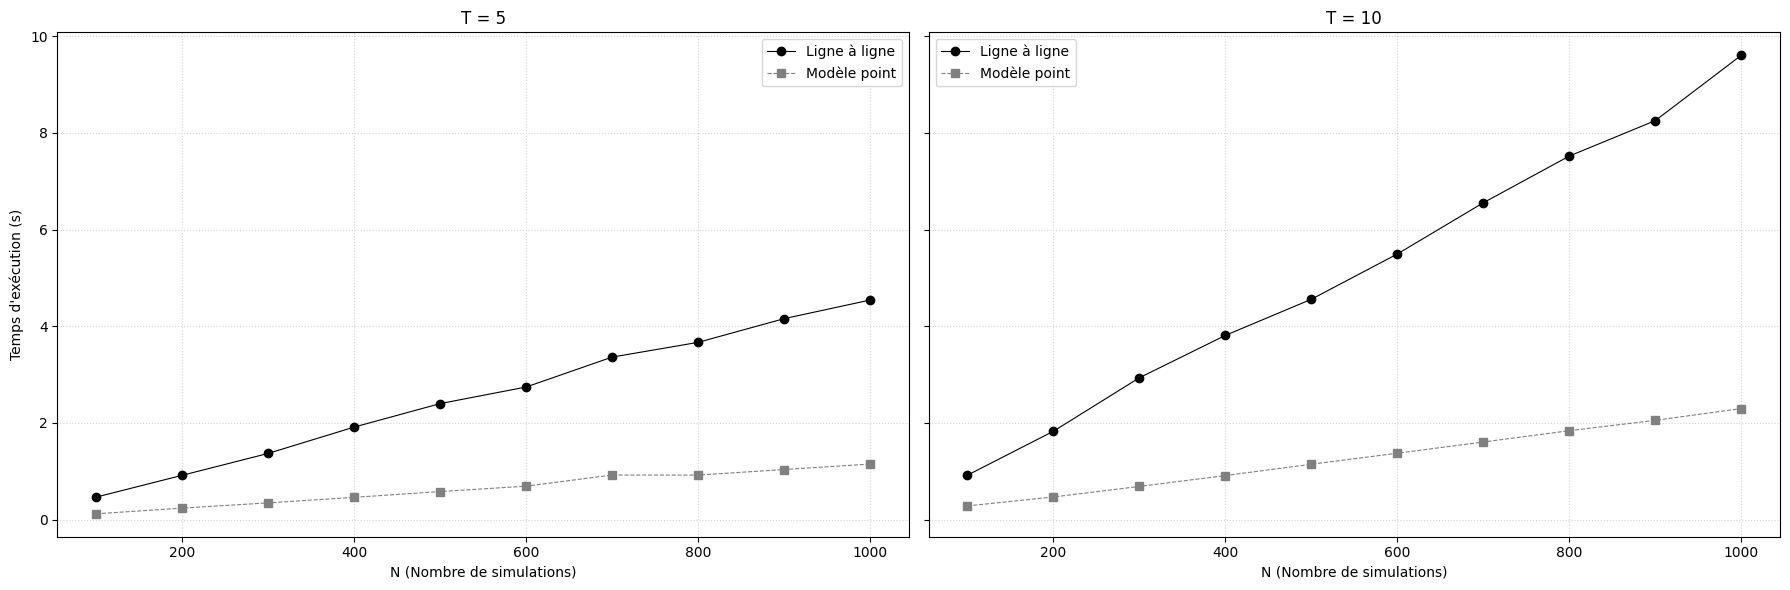

In [1083]:
# ====================== Comparaison temps de calcul ====================== #

# Plage de N (entiers) et les valeurs fixes de T
N_values = np.arange(100, 1100, 100)  # Entiers entre 100 et 1000 avec un pas de 100
T_values_to_plot = [5, 10]  # Les deux valeurs de T que nous allons comparer

# Préparer les données
execution_times_ligne_a_ligne = {T: [] for T in T_values_to_plot}
execution_times_modele_point = {T: [] for T in T_values_to_plot}

# Boucle pour calculer les temps d'exécution
for T in T_values_to_plot:
    for N in N_values:
        # Temps pour la méthode "ligne à ligne"
        start_time = time.time()
        PDD_assets = simulate_multiple_trajectories_multiple_periods_multiple_assets_naive(
            N, S0_actifs, r, Sigma, T, dt, n_assets
        )
        end_time = time.time()
        execution_times_ligne_a_ligne[T].append(end_time - start_time)

        # Temps pour la méthode "modèle point"
        start_time = time.time()
        PDD_model_point, deprecation_prob = simulate_multiple_trajectories_multiple_periods_naive(
            N, S0, r, sigma, T, dt
        )
        end_time = time.time()
        execution_times_modele_point[T].append(end_time - start_time)

# Tracer les graphes 2D côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for i, T in enumerate(T_values_to_plot):
    ax = axes[i]
    ax.plot(
        N_values,
        execution_times_ligne_a_ligne[T],
        label='Ligne à ligne',
        marker='o',
        linestyle='-',
        linewidth=0.8,  # Trait plus fin pour "ligne à ligne"
        color='black'  # Ligne noire
    )
    ax.plot(
        N_values,
        execution_times_modele_point[T],
        label='Modèle point',
        marker='s',
        linestyle='--',
        linewidth=0.8,  # Trait plus fin pour "modèle point"
        color='gray'  # Ligne grise
    )
    ax.set_title(f"T = {T}")
    ax.set_xlabel("N (Nombre de simulations)")
    if i == 0:
        ax.set_ylabel("Temps d'exécution (s)")
    ax.legend()
    ax.grid(True, linestyle=':', color='lightgray')  # Grille discrète en gris clair

# Ajustement de l'affichage
plt.tight_layout()
plt.savefig("tps_calcul.png", dpi=300, bbox_inches="tight")
plt.show()